**Table of contents**<a id='toc0_'></a>    
- [Decoder (GPT)](#toc1_)    
  - [Constants](#toc1_1_)    
  - [Reproducibility](#toc1_2_)    
  - [Utilities](#toc1_3_)    
  - [Config](#toc1_4_)    
  - [Dataset](#toc1_5_)    
    - [Refactor](#toc1_5_1_)    
  - [Construct Batches, Collate Function and DataLoader](#toc1_6_)    
  - [DataLoader](#toc1_7_)    
    - [Example](#toc1_7_1_)    
  - [Model](#toc1_8_)    
    - [Masks](#toc1_8_1_)    
      - [Padding Mask](#toc1_8_1_1_)    
      - [Look-Ahead Mask (Future Mask)](#toc1_8_1_2_)    
      - [Using Both Masks in the Decoder](#toc1_8_1_3_)    
  - [2-Digits Addition](#toc1_9_)    
  - [Adder Decoder Walkthrough](#toc1_10_)    
    - [Target Padding Mask (`target_padding_mask`)](#toc1_10_1_)    
    - [Future Mask (`future_mask`)](#toc1_10_2_)    
    - [Example of Source Padding and Future Masks](#toc1_10_3_)    
      - [First Sample First Token](#toc1_10_3_1_)    
      - [First Sample Fourth Token](#toc1_10_3_2_)    
    - [Further Add a Singleton Dimension in Masks](#toc1_10_4_)    
    - [MultiHeadAttention](#toc1_10_5_)    
      - [A Primer](#toc1_10_5_1_)    
      - [An Example](#toc1_10_5_2_)    
    - [AddNorm (Residual Connection + Layer Normalization)](#toc1_10_6_)    
      - [Residual Block](#toc1_10_6_1_)    
      - [Layer Normalization](#toc1_10_6_2_)    
      - [Combining Both](#toc1_10_6_3_)    
    - [How Loss is Computed?](#toc1_10_7_)    
  - [Potential to use Module Dict?](#toc1_11_)    
  - [Training with GPT-like Model](#toc1_12_)    
    - [Loss Computation](#toc1_12_1_)    
    - [Example](#toc1_12_2_)    
    - [Confusion: Training versus Inference](#toc1_12_3_)    
    - [Training vs Inference](#toc1_12_4_)    
  - [Questions](#toc1_13_)    
    - [Why Masked == 0 in some?](#toc1_13_1_)    
    - [what is the reason of setting the attention scores's mask indexes to negative infinity](#toc1_13_2_)    
    - [Why do we need both ignore index in Loss and also negative infinity mask](#toc1_13_3_)    
    - [Target and Preds/Logits Shape](#toc1_13_4_)    
    - [Why do we flatten prediction and target (logits)?](#toc1_13_5_)    
      - [Background](#toc1_13_5_1_)    
      - [Traditional Loss Computation](#toc1_13_5_2_)    
      - [Why Flatten?](#toc1_13_5_3_)    
      - [Step-by-step Flattening](#toc1_13_5_4_)    
    - [Why sometimes unsqueeze masks?](#toc1_13_6_)    
    - [Why does sequence length differ for source and target, usually I thought it is just all L, same.](#toc1_13_7_)    
    - [Am i right to assume that the core idea of autoregressive model like decoder only (GPT like) is that for a given sample, there will eventually be L rows where L is the seq length, and therefore I can intuitively view it as 1 sample having L samples, since for each row, we will compute the loss. Am I right in my understanding? Do not hesistate to correct me.](#toc1_13_8_)    
    - [QKV Again](#toc1_13_9_)    
      - [Background and Assumptions](#toc1_13_9_1_)    
      - [Context Vector](#toc1_13_9_2_)    
      - [Query (Q), Key (K), and Value (V)](#toc1_13_9_3_)    
      - [Mathematical Description](#toc1_13_9_4_)    
  - [TODO](#toc1_14_)    
  - [References and Further Readings](#toc1_15_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Decoder (GPT)](#toc0_)

In one of the examples provided with minGPT, Karpathy demonstrates training a
GPT model to learn the addition of two numbers presented as strings. This is a
simple task designed to illustrate how a transformer model can be trained on a
sequence-to-sequence task where the input is a sequence of characters
representing an addition operation (like "12 + 35") and the output is the
sequence of characters representing the result of the addition (like "47").

This example serves as a proof-of-concept to show that transformer models, which
are often used for language-related tasks, can learn other patterns or
"languages," such as the "language" of arithmetic. It's a creative way to
showcase the flexibility of the GPT architecture beyond natural language
processing tasks.


In [51]:
from __future__ import annotations

import copy
import math
import os
import random
import time
import unittest
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass, field
from enum import Enum
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import torch
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from typing import List, Tuple, Generator
import numpy as np
import rich
import torch
import torch.nn as nn
# from d2l import torch as d2l
from rich.pretty import pprint
from torch import nn
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader
from tqdm import tqdm

In [52]:
import sys
from pathlib import Path

def find_root_dir(current_path: Path = Path.cwd(), marker: str = '.git') -> Path | None:
    """
    Find the root directory by searching for a directory or file that serves as a
    marker.

    Parameters
    ----------
    current_path : Path
        The starting path to search from.
    marker : str
        The name of the file or directory that signifies the root.

    Returns
    -------
    Path or None
        The path to the root directory. Returns None if the marker is not found.
    """
    current_path = current_path.resolve()
    for parent in current_path.parents:
        if (parent / marker).exists():
            return parent
    return None

current_file_path = Path(os.getcwd())
root_dir          = find_root_dir(current_file_path, marker='omnivault')

if root_dir is not None:
    sys.path.append(str(root_dir))
    from omnivault.transformer.utils.reproducibility import seed_all
    from omnivault.transformer.modules.attention.base import Attention
    from omnivault.transformer.modules.attention.core import ScaledDotProductAttention, MultiHeadedAttention
    from omnivault.transformer.modules.layers.addnorm import AddNorm
    from omnivault.transformer.modules.layers.mlp import PositionwiseFeedForward
    from omnivault.transformer.decoder.core import GPTDecoder, GPTDecoderBlock
    from omnivault.transformer.core.trainer import Trainer
    from omnivault.transformer.core.vocabulary import AdderVocabulary
    from omnivault.transformer.core.dataset import AdderDataset, collate_fn, split_dataset, create_loader
    from omnivault._types._alias import Loss, Accuracy
    from omnivault.transformer.config.constants import MaybeConstant
    from omnivault.transformer.config.global_ import MaybeGlobal
    from omnivault.transformer.config.decoder import *

    from omnivault.transformer.config.composer import Composer, DataConfig
    from omnivault.transformer.config.optim import OptimizerConfig, AdamConfig
else:
    raise ImportError("Root directory not found.")

In [53]:
list(current_file_path.parents)

[PosixPath('/Users/gaohn/gaohn/omniverse/omniverse/transformer'),
 PosixPath('/Users/gaohn/gaohn/omniverse/omniverse'),
 PosixPath('/Users/gaohn/gaohn/omniverse'),
 PosixPath('/Users/gaohn/gaohn'),
 PosixPath('/Users/gaohn'),
 PosixPath('/Users'),
 PosixPath('/')]

## Config

In [54]:
constants: MaybeConstant = MaybeConstant()
global_: MaybeGlobal = MaybeGlobal(seed=42, dataset_size=2)
data_config: DataConfig = DataConfig()
optimizer_config = AdamConfig(name="torch.optim.Adam", lr=0.2, betas=(0.9, 0.98), eps=1e-9)

config = Composer(constants=constants, global_=global_, data=data_config, optimizer=optimizer_config)
pprint(config)

Composer(
│   constants=MaybeConstant(
│   │   NUM_DIGITS=2,
│   │   TOKENS=[
│   │   │   '0',
│   │   │   '1',
│   │   │   '2',
│   │   │   '3',
│   │   │   '4',
│   │   │   '5',
│   │   │   '6',
│   │   │   '7',
│   │   │   '8',
│   │   │   '9',
│   │   │   '+',
│   │   │   '*',
│   │   │   '-',
│   │   │   '=',
│   │   │   '<BOS>',
│   │   │   '<EOS>',
│   │   │   '<PAD>',
│   │   │   '<UNK>'
│   │   ]
│   ),
│   global_=MaybeGlobal(seed=42, debug=False),
│   data=DataConfig(
│   │   dataset_size=2,
│   │   split=[0.7, 0.1, 0.2],
│   │   collate_fn={'batch_first': True, 'pad_token_id': 16},
│   │   train_loader={
│   │   │   'batch_size': 32,
│   │   │   'shuffle': True,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   },
│   │   val_loader={
│   │   │   'batch_size': 32,
│   │   │   'shuffle': False,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   },
│   │   test_loader={
│   │   │   'batch_size': 32,
│   │   │   'shuffle': False,
│   │   │   'num_workers': 0,
│   │   │   'pin_memory': False,
│   │   │   'drop_last': False
│   │   }
│   ),
│   optimizer=AdamConfig(name='torch.optim.Adam', lr=0.2, betas=(0.9, 0.98), eps=1e-09)
)

In [55]:
type(optimizer_config), isinstance(optimizer_config, OptimizerConfig), issubclass(type(optimizer_config), OptimizerConfig)

(omnivault.transformer.config.optim.AdamConfig, True, True)

## <a id='toc1_1_'></a>[Constants](#toc0_)

In [56]:
DEBUG  = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## <a id='toc1_2_'></a>[Reproducibility](#toc0_)

In [57]:
seed_all(config.global_.seed, seed_torch=True, set_torch_deterministic=True)

/Users/gaohn/gaohn/omniverse/omnivault/transformer/utils/reproducibility.py:69: UserWarning: Deterministic mode is activated. This will negatively impact performance.
  configure_deterministic_mode()


42

## <a id='toc1_3_'></a>[Utilities](#toc0_)

In [58]:
def forward_hook(
    module: nn.Module, input: Tuple[torch.Tensor], output: torch.Tensor
) -> None:
    """Custom hook function to print layer information."""
    if not hasattr(module, "has_printed"):
        module.has_printed = False

    if not module.has_printed:
        print(f"Layer: {module.__class__.__name__}")
        print(f"Input shape: {str(input[0].shape)}")
        print(f"Output shape: {str(output.shape)}")
        module.has_printed = True


def are_both_models_same(state_dict_1, state_dict_2):
    # Check if both models have the same keys
    if set(state_dict_1.keys()) != set(state_dict_2.keys()):
        return False

    # Check if all tensors have the same shape and values
    for key in state_dict_1.keys():
        if state_dict_1[key].shape != state_dict_2[key].shape:
            return False
        if not torch.allclose(state_dict_1[key], state_dict_2[key]):
            return False

    return True
    # return model_1.state_dict().__str__() == model_2.state_dict().__str__()

## <a id='toc1_5_'></a>[Dataset](#toc0_)

In [59]:
vocab = AdderVocabulary.from_tokens(tokens=config.constants.TOKENS, num_digits=config.constants.NUM_DIGITS)
token_to_index = vocab.token_to_index
index_to_token = vocab.index_to_token
vocab_size = vocab.vocab_size
pprint(token_to_index)
pprint(index_to_token)
pprint(vocab_size)

PAD = vocab.token_to_index[vocab.PAD]
UNK = vocab.token_to_index[vocab.UNK]
ADD = vocab.token_to_index[vocab.ADD]
EQUAL = vocab.token_to_index[vocab.EQUAL]
BOS = vocab.token_to_index[vocab.BOS]
EOS = vocab.token_to_index[vocab.EOS]

{
│   '0': 0,
│   '1': 1,
│   '2': 2,
│   '3': 3,
│   '4': 4,
│   '5': 5,
│   '6': 6,
│   '7': 7,
│   '8': 8,
│   '9': 9,
│   '+': 10,
│   '*': 11,
│   '-': 12,
│   '=': 13,
│   '<BOS>': 14,
│   '<EOS>': 15,
│   '<PAD>': 16,
│   '<UNK>': 17
}

{
│   0: '0',
│   1: '1',
│   2: '2',
│   3: '3',
│   4: '4',
│   5: '5',
│   6: '6',
│   7: '7',
│   8: '8',
│   9: '9',
│   10: '+',
│   11: '*',
│   12: '-',
│   13: '=',
│   14: '<BOS>',
│   15: '<EOS>',
│   16: '<PAD>',
│   17: '<UNK>'
}

18

In [60]:
def pad_number(num: int, length: int) -> str:
    """
    Pad numbers with zeros in front so that they have uniform length.

    Note, if a + b = c and num digits allowed to add is 2, then for
    a and b we always pad to length 2, but for c we always pad to length 3.

    Example
    -------
    6 + 90 = 96 -> 06 + 90 = 096

    Parameters
    ----------
    num : int
        Number to be padded.
    num_digits : int
        Length of the resulting padded number string.

    Returns
    -------
    str
        Padded number string.
    """
    return str(num).zfill(length)


def equation_to_string(a: int, b: int, c: int, num_digits: int) -> str:
    """
    Formats the addition equation as a string.

    Parameters
    ----------
    a : int
        First addend.
    b : int
        Second addend.
    c : int
        Sum of a and b.
    num_digits : int
        Number of digits each number in the equation should have.

    Returns
    -------
    str
        Formatted equation string.
    """
    padded_a = pad_number(a, num_digits)
    padded_b = pad_number(b, num_digits)
    padded_c = pad_number(c, num_digits + 1) # note the padding here!
    return f"{padded_a}+{padded_b}={padded_c}"

def decode_equation(vocab: AdderVocabulary, equation: torch.Tensor | List[int]) -> str:
    """
    Convert an equation in list format to string format.

    Parameters
    ----------
    equation : List[int]
        The equation in list format.

    Returns
    -------
    str
        The equation in string format.
    """
    if isinstance(equation, torch.Tensor):
        equation = equation.tolist()

    UNK = vocab.token_to_index[vocab.UNK]
    decoded_equation = "".join([str(index_to_token.get(x, UNK)) for x in equation])
    return decoded_equation.replace("<BOS>", "").replace("<EOS>", "")

def batch_decode_equation(vocab: AdderVocabulary, equations: torch.Tensor | List[List[int]]) -> List[str]:
    decoded_equations = []
    for equation in equations:
        decoded_equation = decode_equation(vocab, equation)
        decoded_equations.append(decoded_equation)
    return decoded_equations

def encode_equation(vocab: AdderVocabulary, equation: str, num_digits: int) -> torch.Tensor:
    """
    Convert an equation (up to the equal sign in it) in string format to a list.

    Parameters
    ----------
    equation : str
        The equation in string format.
    num_digits : int
        Number of digits each number in the equation should have.

    Returns
    -------
    torch.Tensor
        The equation in list format as a tensor.
    """
    plus_idx = equation.index(vocab.ADD)
    equal_idx = equation.index(vocab.EQUAL)

    BOS = vocab.token_to_index[vocab.BOS]
    UNK = vocab.token_to_index[vocab.UNK]

    a = pad_number(int(equation[:plus_idx]), num_digits)
    b = pad_number(int(equation[plus_idx + 1:equal_idx]), num_digits)

    new_equation = f"{a}+{b}="

    return torch.tensor(
        [BOS] + [token_to_index.get(n, UNK) for n in new_equation],
        dtype=torch.int
    ).to(DEVICE)

In [61]:
def create_add_dataset(
    vocab: AdderVocabulary, num_digits: int, dataset_size: int, rng_seed: int = 1337
) -> Tuple[List[torch.Tensor], List[str]]:
    BOS = vocab.token_to_index[vocab.BOS]
    EOS = vocab.token_to_index[vocab.EOS]
    UNK = vocab.token_to_index[vocab.UNK]

    rng = torch.Generator()
    rng.manual_seed(rng_seed)

    max_num = 10**num_digits - 1

    dataset_str = []
    for _ in range(dataset_size):
        a = torch.randint(low=0, high=max_num + 1, size=(1,), generator=rng).item()
        b = torch.randint(low=0, high=max_num + 1, size=(1,), generator=rng).item()
        c = a + b

        equation = equation_to_string(a, b, c, num_digits)

        dataset_str.append(equation)

    dataset_tensor = [
        torch.tensor([BOS] + [token_to_index.get(n, UNK) for n in x] + [EOS])
        for x in dataset_str
    ]
    return dataset_tensor, dataset_str

In [62]:
dataset_tensor, dataset_str = create_add_dataset(vocab=vocab, num_digits=2, dataset_size=4)
pprint(dataset_tensor)
pprint(dataset_str)

decode_equation(vocab, dataset_tensor[0]), decode_equation(vocab, [15, 1, 5, 10, 5, 7, 13,  0, 7,  2, 14])

[
│   tensor([14,  1,  5, 10,  5,  7, 13,  0,  7,  2, 15]),
│   tensor([14,  9,  2, 10,  0,  0, 13,  0,  9,  2, 15]),
│   tensor([14,  9,  5, 10,  5,  3, 13,  1,  4,  8, 15]),
│   tensor([14,  1,  5, 10,  1,  0, 13,  0,  2,  5, 15])
]

['15+57=072', '92+00=092', '95+53=148', '15+10=025']

('15+57=072', '15+57=072')

In [63]:
encode_equation(vocab, "01+02=", num_digits=2), encode_equation(vocab, "01+02=", num_digits=2).tolist()

(tensor([14,  0,  1, 10,  0,  2, 13], dtype=torch.int32),
 [14, 0, 1, 10, 0, 2, 13])

Some notes:

1. We included other operations besides addition for future use. So it may seem redundant for now.
2. Kapathy's version is more efficient since for an expression such as `15+87=102` would be encoded as `1587102` since for one, we restrict the `num_digits` to be fixed, this means that if `num_digits=2`, then it follows that only numbers that are less or equals to 2 digits can be added together. As a result, `1587102` will always be interpreted as first 2 digit = first num, next 2 digits = second num, last 3 digits as third or the answer (sum of first two). Let's look at two more examples to appreciate this:
   1. `0639045 <> 6 + 39 = 45`
   2. `5101052 <> 51 + 1 = 52`
3. He also encoded the answer backwards because its easier for GPT model, but for a first review, I will not do so to avoid confusion.

KAPATHY:

As one more example, the problem 6 + 39 = 45 would be encoded as:

"0639054"

where you will notice that we are padding with zeros to make sure that we always
produce strings of the exact same size: n + n + (n + 1). When n=2, this is 7.
At test time, we will feed in an addition problem by giving the first 2n digits,
and hoping that the GPT model completes the sequence with the next (n+1) digits
correctly.

TODO: to make it inherit Dataset.

## <a id='toc1_6_'></a>[Construct Batches, Collate Function and DataLoader](#toc0_)

DISTINGUISH BETWEEN GPT DECODER ONLY VS ENCODER DECODER SEQ TO SEQ

In [64]:
# construct_future_mask(seq_len=3)[:, None, None, :]

## <a id='toc1_7_'></a>[DataLoader](#toc0_)

In [65]:
config.data.train_loader["batch_size"] = 2
config.data.val_loader["batch_size"] = 2
config.data.test_loader["batch_size"] = 2
config.data.dataset_size = 8
config.data.split = [1, 0, 0]
config.global_.seed = 1337

vocab = AdderVocabulary.from_tokens(tokens=config.constants.TOKENS, num_digits=config.constants.NUM_DIGITS)
dataset_tensor, dataset_str = create_add_dataset(vocab=vocab, num_digits=config.constants.NUM_DIGITS, dataset_size=config.data.dataset_size)
adder_dataset = AdderDataset(data=dataset_str, vocabulary=vocab)

pprint(config.data)

train_dataset, val_dataset, test_dataset = split_dataset(
    dataset=adder_dataset,
    split=config.data.split,
    seed=config.global_.seed
)


train_loader = create_loader(
    dataset=train_dataset,
    loader_config=config.data.train_loader,
    collate_fn_config=config.data.collate_fn,
)

val_loader = create_loader(
    dataset=val_dataset,
    loader_config=config.data.val_loader,
    collate_fn_config=config.data.collate_fn,
)

test_loader = create_loader(
    dataset=test_dataset,
    loader_config=config.data.test_loader,
    collate_fn_config=config.data.collate_fn,
)

DataConfig(
│   dataset_size=8,
│   split=[1, 0, 0],
│   collate_fn={'batch_first': True, 'pad_token_id': 16},
│   train_loader={'batch_size': 2, 'shuffle': True, 'num_workers': 0, 'pin_memory': False, 'drop_last': False},
│   val_loader={'batch_size': 2, 'shuffle': False, 'num_workers': 0, 'pin_memory': False, 'drop_last': False},
│   test_loader={'batch_size': 2, 'shuffle': False, 'num_workers': 0, 'pin_memory': False, 'drop_last': False}
)

/opt/homebrew/Caskroom/miniconda/base/envs/omniverse/lib/python3.9/site-packages/torch/utils/data/dataset.py:414: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/opt/homebrew/Caskroom/miniconda/base/envs/omniverse/lib/python3.9/site-packages/torch/utils/data/dataset.py:414: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [66]:
seed_all(133338, seed_torch=True)

for batch in train_loader:
    # Each batch is a tuple containing all elements for the batch
    inputs_padded, targets_padded, padding_masks_padded_and_expanded, future_masks_expanded = batch

    # Print the length of each component in the batch
    print("Batch Size:", len(inputs_padded))  # This prints the number of samples in the batch

    # Now you can print shapes or other properties of each batch element
    print("Inputs Shape:", inputs_padded.shape)
    print("Targets Shape:", targets_padded.shape)

    # Decoding and other processing can be done here
    # For example, decoding the first sequence in the batch
    print("Decoded Equation:", decode_equation(vocab, inputs_padded[0].tolist()))

    print("-" * 80)


Batch Size: 2
Inputs Shape: torch.Size([2, 10])
Targets Shape: torch.Size([2, 10])
Decoded Equation: 95+53=148
--------------------------------------------------------------------------------
Batch Size: 2
Inputs Shape: torch.Size([2, 10])
Targets Shape: torch.Size([2, 10])
Decoded Equation: 34+90=124
--------------------------------------------------------------------------------
Batch Size: 2
Inputs Shape: torch.Size([2, 10])
Targets Shape: torch.Size([2, 10])
Decoded Equation: 12+20=032
--------------------------------------------------------------------------------
Batch Size: 2
Inputs Shape: torch.Size([2, 10])
Targets Shape: torch.Size([2, 10])
Decoded Equation: 90+38=128
--------------------------------------------------------------------------------


Note here the padding in collate is "redundant" since in our earlier code
we ensured that all sample has same number of characters by way of padding
zeros in front. For example, `23 + 3 =26` will become `23 + 03 = 026`. Consequently,
all samples $\in$ batch will have same length by definition.

### <a id='toc1_7_1_'></a>[Example](#toc0_)

In [67]:
# import torch
# from typing import List
# from torch.utils.data import DataLoader, TensorDataset

# sequences = [
#     torch.tensor([1, 2]),
#     torch.tensor([3, 4, 5]),
#     torch.tensor([6, 7, 8, 9]),
#     torch.tensor([2, 3]),
# ]
# # Let's say PAD is represented by the integer 16
# PAD = 16
# sample_dataloader = DataLoader(
#     sequences,
#     batch_size=4,
#     collate_fn=lambda b: collate_fn(b, batch_first=True, padding_value=PAD),
# )
# batch = next(iter(sample_dataloader))
# pprint(batch)

# # Create the pad mask
# pad_mask = batch == PAD
# print(pad_mask)


In PyTorch, `input == PAD` will perform element-wise comparison between each element of the `input` tensor and the constant `PAD`. The `PAD` constant is usually an integer that represents the padding token in a sequence. For example, in NLP tasks, padding tokens are often used to make all sequences in a batch the same length.

If `input` is a tensor of shape `(Batch Size, Sequence Length)`, then `input == PAD` will return a boolean tensor of the same shape, where each element at position `(i, j)` will be `True` if `input[i, j]` is equal to `PAD`, and `False` otherwise. This boolean tensor will serve as a mask that identifies where the padding tokens are located in the original `input` tensor.

---

The `src_mask` term in the context of transformers typically refers to the "source mask," which is designed to prevent the self-attention mechanism from considering certain tokens in the source sequence. This mask is applied to the attention scores before the softmax operation during the calculation of self-attention. The primary purposes of using such a mask are:

1. Padding Masking: When sequences are batched together, shorter sequences are often padded with special tokens (usually denoted by zeros or a specific padding token) to match the length of the longest sequence in the batch. The `src_mask` helps the model ignore these padding tokens by setting the corresponding attention scores to a large negative value (usually `-inf`), so that they become zero after the softmax operation.

2. Future Information Masking: In some tasks like sequence-to-sequence prediction, it's important that a token does not attend to future tokens in the sequence. This is another use-case for the mask, although this is more commonly seen in the target mask (`tgt_mask`) rather than the source mask (`src_mask`).

To determine whether `src_mask` in a specific implementation is the padding mask from the dataloader, you'll need to check the code where this variable is defined or used. Typically, if the mask is intended to filter out padding tokens, then yes, it could very well be the same as the padding mask generated during data loading.

The actual implementation may vary, but the concept generally remains the same. You'll often see the mask being used in the self-attention calculation, specifically right before the softmax operation to zero out particular positions.

---

What are `pad_mask`?

The primary reason for using a padding mask (`pad_mask`) is to ensure that the model does not consider padding tokens during training or inference. Padding tokens are usually added to sequences to make them have a uniform length, but they don't carry any meaningful information. Ignoring them is crucial for several reasons:

1. **Attention Mechanisms**: If your model uses attention, the mask ensures that attention scores for padding tokens are set to a very low value (often negative infinity), so that these scores don't affect the weighted sum of the input sequence.

2. **Loss Computation**: When computing loss, padding tokens should not contribute. Including them could mislead the model during training, as they don't represent genuine mistakes in prediction.

3. **Output Interpretation**: When the model makes predictions, padding tokens should not be taken into account for tasks like sequence-to-sequence translation, summarization, etc.

4. **Computational Efficiency**: In some models or algorithms, knowing which tokens are padding can speed up computation by allowing the model to skip unnecessary operations.

In summary, the padding mask is a utility to ensure that the model focuses only on the meaningful parts of the input sequence, thereby improving both accuracy and computational efficiency.

In [68]:
batch = next(iter(train_loader))
batch

(tensor([[14,  9,  0, 10,  3,  8, 13,  1,  2,  8],
         [14,  1,  5, 10,  5,  7, 13,  0,  7,  2]]),
 tensor([[16, 16, 16, 16, 16, 16,  1,  2,  8, 15],
         [16, 16, 16, 16, 16, 16,  0,  7,  2, 15]]),
 tensor([[[[True, True, True, True, True, True, True, True, True, True],
           [True, True, True, True, True, True, True, True, True, True],
           [True, True, True, True, True, True, True, True, True, True],
           [True, True, True, True, True, True, True, True, True, True],
           [True, True, True, True, True, True, True, True, True, True],
           [True, True, True, True, True, True, True, True, True, True],
           [True, True, True, True, True, True, True, True, True, True],
           [True, True, True, True, True, True, True, True, True, True],
           [True, True, True, True, True, True, True, True, True, True],
           [True, True, True, True, True, True, True, True, True, True]]],
 
 
         [[[True, True, True, True, True, True, True, Tr

WHY concat target instead of stack them normally?

In [69]:
# construct_batches(batch)[0].shape, construct_batches(batch)[1].shape, construct_batches(batch)[2].shape

## <a id='toc1_8_'></a>[Model](#toc0_)

### <a id='toc1_8_1_'></a>[Masks](#toc0_)

In Transformer models, especially in the decoder, two types of masks are commonly used: padding masks and look-ahead masks (or future masks). Here's why each is important and why you might need both:

#### <a id='toc1_8_1_1_'></a>[Padding Mask](#toc0_)

1. **Why it's needed**: When you're dealing with sequences of different lengths, you pad the shorter sequences with zeros to make them the same length as the longest one in the batch. These zero-paddings should not contribute to the output of the attention mechanism.
  
2. **Where it's used**: Both the encoder and the decoder use padding masks.

3. **How it works**: The padding mask marks the padded positions so that they can be excluded from contributing to the attention mechanism. In practice, you'll typically set the corresponding attention scores to negative infinity before applying the softmax operation.

#### <a id='toc1_8_1_2_'></a>[Look-Ahead Mask (Future Mask)](#toc0_)

1. **Why it's needed**: In the decoder, each position can only attend to positions that come before it in the sequence to maintain the auto-regressive property. This is different from the encoder, where all positions can attend to all other positions.

2. **Where it's used**: This mask is specifically for the decoder.

3. **How it works**: The look-ahead mask is used to mask out future positions (i.e., positions that come after the current position) so that they don't contribute to the current attention scores. Before the softmax operation, you'll mark these positions so that their contributions are effectively zero.

#### <a id='toc1_8_1_3_'></a>[Using Both Masks in the Decoder](#toc0_)

It's possible to use both types of masks in the decoder to address different requirements:

- Padding mask is for ignoring padded positions.
- Look-ahead mask is for ensuring that each position only attends to positions before it in the sequence.



## <a id='toc1_9_'></a>[2-Digits Addition](#toc0_)

- `max_len` example: `<BOS>90+38=128<EOS>`
  - another reminder our max len in this example is same but this is on purpose.

In [70]:
# dataset, dataset_str = create_add_dataset(vocab, self.num_digits, self.dataset_size)

# # write dataset_str to a file
# # with open("dataset_str.txt", "w") as f:
# #     for item in dataset_str:
# #         f.write("%s\n" % item)


In [71]:
rng_seed     = 1992
dataset_size = 10000
batch_size   = 256

config.data.train_loader["batch_size"] = batch_size
config.data.val_loader["batch_size"] = batch_size
config.data.test_loader["batch_size"] = batch_size
config.data.split = [0.7, 0.2, 0.1]
config.data.dataset_size = dataset_size
config.global_.seed = rng_seed

num_digits = config.constants.NUM_DIGITS
pprint(config.data)

with open("../dataset_str.txt", "r") as file:
    data = [line.strip() for line in file]

vocab = AdderVocabulary.from_tokens(tokens=config.constants.TOKENS, num_digits=config.constants.NUM_DIGITS)
adder_dataset = AdderDataset(data=data, vocabulary=vocab)

train_dataset, val_dataset, test_dataset = split_dataset(
    dataset=adder_dataset,
    split=config.data.split,
    seed=config.global_.seed
)


train_loader = create_loader(
    dataset=train_dataset,
    loader_config=config.data.train_loader,
    collate_fn_config=config.data.collate_fn,
)

val_loader = create_loader(
    dataset=val_dataset,
    loader_config=config.data.val_loader,
    collate_fn_config=config.data.collate_fn,
)

test_loader = create_loader(
    dataset=test_dataset,
    loader_config=config.data.test_loader,
    collate_fn_config=config.data.collate_fn,
)

train_size, val_size, test_size = len(train_dataset), len(val_dataset), len(test_dataset)

# max_len is determined by 1+ num_digits + 1 + num_digits + 1 + num_digits + 1 + 1
# where the 1s represent BOS, Plus sign, Equal sign, the extra digit in the sum, EOS, respectively.
max_len = 1 + 1 + 1 + 1 + 2 * num_digits + (num_digits + 1)


DataConfig(
│   dataset_size=10000,
│   split=[0.7, 0.2, 0.1],
│   collate_fn={'batch_first': True, 'pad_token_id': 16},
│   train_loader={'batch_size': 256, 'shuffle': True, 'num_workers': 0, 'pin_memory': False, 'drop_last': False},
│   val_loader={'batch_size': 256, 'shuffle': False, 'num_workers': 0, 'pin_memory': False, 'drop_last': False},
│   test_loader={'batch_size': 256, 'shuffle': False, 'num_workers': 0, 'pin_memory': False, 'drop_last': False}
)

In [72]:
# Create individual component configurations
masked_self_attention_mha_config = MultiHeadedAttentionConfig(
     attention=ScaledDotProductAttention(),
    d_model=128, H=4, dropout=0.1
)

feed_forward_config = PositionwiseFeedForwardConfig(
    d_model=128, d_ff=256, activation=nn.GELU(approximate="tanh"), dropout=0.1, bias=True
)

add_norm_config_1 = AddNormConfig(feature_dim=128, dropout=0.1)
add_norm_config_2 = AddNormConfig(feature_dim=128, dropout=0.1)

# Create DecoderBlockConfig
decoder_block_config = DecoderBlockConfig(
    masked_self_attention_mha=masked_self_attention_mha_config,
    feed_forward=feed_forward_config,
    add_norm_1=add_norm_config_1,
    add_norm_2=add_norm_config_2,
)

# Create the overall DecoderConfig
model_config = DecoderConfig(
    d_model=128,
    vocab_size=vocab_size,  # You'll need to specify this based on your dataset
    max_seq_len=max_len,  # Assuming max_len is defined elsewhere in your code
    num_decoder_blocks=2,
    dropout=0.1,
    decoder_block=decoder_block_config,
)

model = GPTDecoder(model_config).to(DEVICE)

model_size = sum([p.numel() for p in model.parameters()])
print(f'model_size: {model_size}, train_set_size: {train_size}')

model_size: 270226, train_set_size: 7000


In [73]:
# warmup_steps = 3*len(dataloaders.train_loader)
warmup_steps = 3 * len(train_loader)


# lr first increases in the warmup steps, and then descreases
lr_fn        = lambda step: model_config.d_model**(-0.5) * min([(step+1)**(-0.5), (step+1)*warmup_steps**(-1.5)])
# optimizer    = torch.optim.Adam(model.parameters(), lr=0.2, betas=(0.9, 0.98), eps=1e-9)

# optimizer_config = OptimizerConfig(name="torch.optim.Adam", lr=0.2, betas=(0.9, 0.98), eps=1e-9)
# optimizer   = optimizer_config.build(params=model.parameters())

# optimizer_config = OptimizerConfig(name="torch.optim.Adam", lr=0.2)
# optimizer   = optimizer_config.build(params=model.parameters(), betas=(0.9, 0.98), eps=1e-9)

optimizer   = config.optimizer.build(params=model.parameters())

scheduler    = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_fn)
criterion    = nn.CrossEntropyLoss(ignore_index=PAD, reduction="mean")


@dataclass
class Metrics:
    loss: Loss
    accuracy: Accuracy

1. `input` is indeed `[bs, 10]` because max len is 11, so removed last token.
2. `target` should be `[bs, 10]` but left shifted of the real original input but somehow i got 11.
3. Think of vocab size to be num classes in my classification problem. But the

In [74]:
trainer = Trainer(
    model=model,
    train_dataloader=train_loader,
    valid_dataloader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    grad_norm_clip=1.0,
    device=DEVICE,
    # test_dataloader=test_loader,
    # NOTE: uncomment the above line to enable testing after each epoch
    # but seeding will affect.
)

if DEBUG:
    trained_model = trainer.fit(num_epochs=2) # or 15
    # torch.save(model.state_dict(), 'model_debug.pt')
    # model_debug = torch.load('./model_debug.pt')
    # if are_both_models_same(model.state_dict(), model_debug):
    #     print("Pass")
    # else:
    #     print("Fail")

else:
    trained_model = trainer.fit(num_epochs=30)

    # torch.save(model.state_dict(), 'model_non_debug.pt')

Epoch 1/30
----------


100%|██████████| 8/8 [00:00<00:00, 26.79it/s]


Training Loss   : 2.10712
Validation Loss : 1.27872
Epoch 2/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.50it/s]


Training Loss   : 1.23133
Validation Loss : 1.09508
Epoch 3/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.82it/s]


Training Loss   : 1.03519
Validation Loss : 0.87629
Epoch 4/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.95it/s]


Training Loss   : 0.87725
Validation Loss : 0.78361
Epoch 5/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.38it/s]


Training Loss   : 0.79957
Validation Loss : 0.73302
Epoch 6/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.59it/s]


Training Loss   : 0.76029
Validation Loss : 0.69880
Epoch 7/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.77it/s]


Training Loss   : 0.72721
Validation Loss : 0.68126
Epoch 8/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.49it/s]


Training Loss   : 0.70416
Validation Loss : 0.63668
Epoch 9/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.36it/s]


Training Loss   : 0.64809
Validation Loss : 0.48974
Epoch 10/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.36it/s]


Training Loss   : 0.39999
Validation Loss : 0.16127
Epoch 11/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.67it/s]


Training Loss   : 0.20621
Validation Loss : 0.08199
Epoch 12/30
----------


100%|██████████| 8/8 [00:00<00:00, 28.95it/s]


Training Loss   : 0.13922
Validation Loss : 0.05043
Epoch 13/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.30it/s]


Training Loss   : 0.11169
Validation Loss : 0.03682
Epoch 14/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.15it/s]


Training Loss   : 0.08848
Validation Loss : 0.02700
Epoch 15/30
----------


100%|██████████| 8/8 [00:00<00:00, 27.12it/s]


Training Loss   : 0.07917
Validation Loss : 0.02183
Epoch 16/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.44it/s]


Training Loss   : 0.06974
Validation Loss : 0.01599
Epoch 17/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.28it/s]


Training Loss   : 0.05679
Validation Loss : 0.01285
Epoch 18/30
----------


100%|██████████| 8/8 [00:00<00:00, 25.26it/s]


Training Loss   : 0.04896
Validation Loss : 0.00878
Epoch 19/30
----------


100%|██████████| 8/8 [00:00<00:00, 28.38it/s]


Training Loss   : 0.04387
Validation Loss : 0.00921
Epoch 20/30
----------


100%|██████████| 8/8 [00:00<00:00, 27.63it/s]


Training Loss   : 0.04160
Validation Loss : 0.00447
Epoch 21/30
----------


100%|██████████| 8/8 [00:00<00:00, 23.46it/s]


Training Loss   : 0.03468
Validation Loss : 0.00423
Epoch 22/30
----------


100%|██████████| 8/8 [00:00<00:00, 28.56it/s]


Training Loss   : 0.03085
Validation Loss : 0.00279
Epoch 23/30
----------


100%|██████████| 8/8 [00:00<00:00, 27.92it/s]


Training Loss   : 0.02741
Validation Loss : 0.00197
Epoch 24/30
----------


100%|██████████| 8/8 [00:00<00:00, 28.90it/s]


Training Loss   : 0.02015
Validation Loss : 0.00132
Epoch 25/30
----------


100%|██████████| 8/8 [00:00<00:00, 28.80it/s]


Training Loss   : 0.01844
Validation Loss : 0.00229
Epoch 26/30
----------


100%|██████████| 8/8 [00:00<00:00, 26.33it/s]


Training Loss   : 0.01913
Validation Loss : 0.00103
Epoch 27/30
----------


100%|██████████| 8/8 [00:00<00:00, 28.46it/s]


Training Loss   : 0.01545
Validation Loss : 0.00076
Epoch 28/30
----------


100%|██████████| 8/8 [00:00<00:00, 29.01it/s]


Training Loss   : 0.01616
Validation Loss : 0.00104
Epoch 29/30
----------


100%|██████████| 8/8 [00:00<00:00, 28.69it/s]


Training Loss   : 0.01504
Validation Loss : 0.00092
Epoch 30/30
----------


100%|██████████| 8/8 [00:00<00:00, 28.27it/s]

Training Loss   : 0.01006
Validation Loss : 0.00047
Training complete


```
Epoch 1/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.22it/s]
100%|██████████| 8/8 [00:00<00:00, 29.15it/s]
Training Loss   : 2.10712
Validation Loss : 1.27872
Epoch 2/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.78it/s]
100%|██████████| 8/8 [00:00<00:00, 29.36it/s]
Training Loss   : 1.23133
Validation Loss : 1.09508
```

In [75]:
trained_model

GPTDecoder(
  (tok_embed): Embedding(18, 128)
  (decoder_blocks): ModuleList(
    (0-1): 2 x GPTDecoderBlock(
      (masked_self_attention_mha): MultiHeadedAttention(
        (W_Q): Linear(in_features=128, out_features=128, bias=False)
        (W_K): Linear(in_features=128, out_features=128, bias=False)
        (W_V): Linear(in_features=128, out_features=128, bias=False)
        (W_O): Linear(in_features=128, out_features=128, bias=False)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): PositionwiseFeedForward(
        (ffn): ModuleDict(
          (context_fc): Linear(in_features=128, out_features=256, bias=True)
          (activation): GELU(approximate='tanh')
          (context_projection): Linear(in_features=256, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (add_norm_1): AddNorm(
        

In [76]:
batch = next(iter(train_loader))
pprint(batch)

inputs, targets, target_padding_masks, future_masks = batch


# Step 2: Pass the sample through the model
trained_model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    # Assuming your model and sample require specific formatting, adjust as necessary
    logits = model(inputs, target_padding_masks=target_padding_masks, future_masks=future_masks)

(
│   tensor([[14,  8,  8,  ...,  1,  1,  2],
│   │   [14,  5,  3,  ...,  1,  0,  2],
│   │   [14,  0,  5,  ...,  0,  7,  5],
│   │   ...,
│   │   [14,  7,  9,  ...,  1,  2,  9],
│   │   [14,  0,  1,  ...,  0,  8,  4],
│   │   [14,  1,  6,  ...,  0,  5,  8]]),
│   tensor([[16, 16, 16,  ...,  1,  2, 15],
│   │   [16, 16, 16,  ...,  0,  2, 15],
│   │   [16, 16, 16,  ...,  7,  5, 15],
│   │   ...,
│   │   [16, 16, 16,  ...,  2,  9, 15],
│   │   [16, 16, 16,  ...,  8,  4, 15],
│   │   [16, 16, 16,  ...,  5,  8, 15]]),
│   tensor([[[[True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     ...,
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True]]],
│   │   
│   │   
│   │   [[[True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     ...,
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True]]],
│   │   
│   │   
│   │   [[[True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     ...,
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True]]],
│   │   
│   │   
│   │   ...,
│   │   
│   │   
│   │   [[[True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     ...,
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True]]],
│   │   
│   │   
│   │   [[[True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     ...,
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True]]],
│   │   
│   │   
│   │   [[[True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     ...,
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True],
│   │     [True, True, True,  ..., True, True, True]]]]),
│   tensor([[[[ True, False, False,  ..., False, False, False],
│   │     [ True,  True, False,  ..., False, False, False],
│   │     [ True,  True,  True,  ..., False, False, False],
│   │     ...,
│   │     [ True,  True,  True,  ...,  True, False, False],
│   │     [ True,  True,  True,  ...,  True,  True, False],
│   │     [ True,  True,  True,  ...,  True,  True,  True]]],
│   │   
│   │   
│   │   [[[ True, False, False,  ..., False, False, False],
│   │     [ True,  True, False,  ..., False, False, False],
│   │     [ True,  True,  True,  ..., False, False, False],
│   │     ...,
│   │     [ True,  True,  True,  ...,  True, False, False],
│   │     [ True,  True,  True,  ...,  True,  True, False],
│   │     [ True,  True,  True,  ...,  True,  True,  True]]],
│   │   
│   │   
│   │   [[[ True, False, False,  ..., False, False, False],
│   │     [ True,  True, False,  ..., False, False, False],
│   │     [ True,  True,  True,  ..., False, False, False],
│   │     ...,
│   │     [ True,  True,  True,  ...,  True, False, False],
│   │     [ True,  True,  True,  ...,  True,  True, False],
│   │     [ True,  True,  True,  ...,  True,  True,  True]]],
│   │   
│   │   
│   │   ...,
│   │   
│   │   
│   │   [[[ True, False, False,  ..., False, False, False],
│   │     [ True,  True, Fa

In [77]:
last_decoder_block = trained_model.decoder_blocks[-1] # take last decoder block? more feature?
# pprint(last_decoder_block)

masked_self_attention_mha = last_decoder_block.masked_self_attention_mha
pprint(masked_self_attention_mha)

context_vector, attention_weights = masked_self_attention_mha.context_vector, masked_self_attention_mha.attention_weights
pprint(attention_weights.shape)
# but has H=4 heads so do we take 1 head and check the heatmap?
# torch.Size([208, 4, 10, 10])

last_batch_last_sample_first_head_attention_weights = attention_weights[-1, 0:1, :, :].squeeze(0)
pprint(last_batch_last_sample_first_head_attention_weights.shape)


MultiHeadedAttention(
  (W_Q): Linear(in_features=128, out_features=128, bias=False)
  (W_K): Linear(in_features=128, out_features=128, bias=False)
  (W_V): Linear(in_features=128, out_features=128, bias=False)
  (W_O): Linear(in_features=128, out_features=128, bias=False)
  (attention): ScaledDotProductAttention(
│   (dropout): Dropout(p=0.0, inplace=False)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)

torch.Size([256, 4, 10, 10])

torch.Size([10, 10])

the xy axis is keys and queries, which is correct `Q @ K.T`

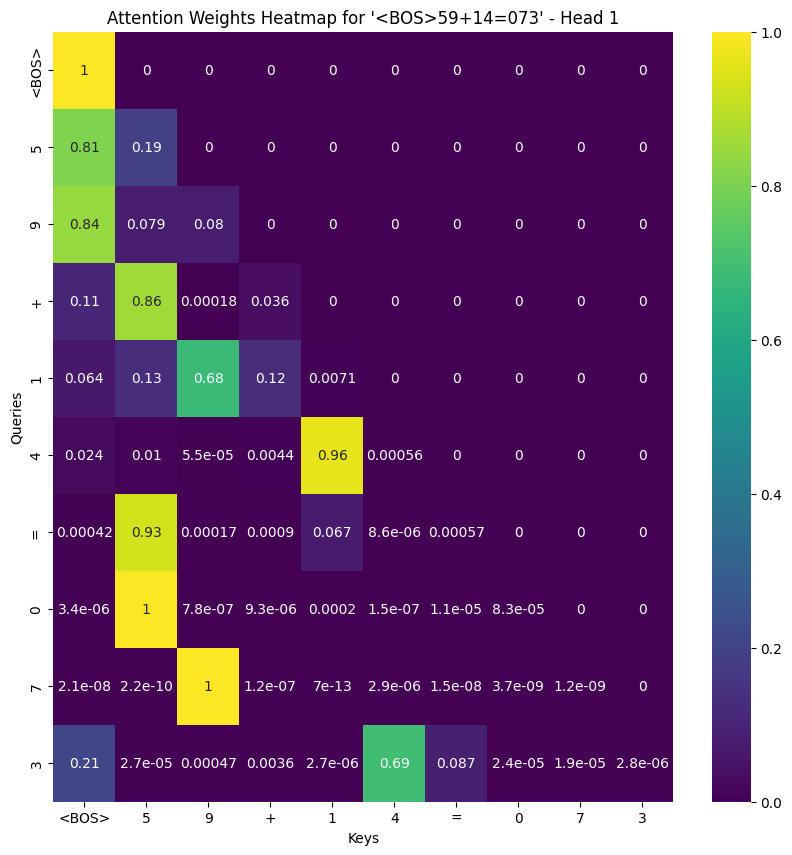

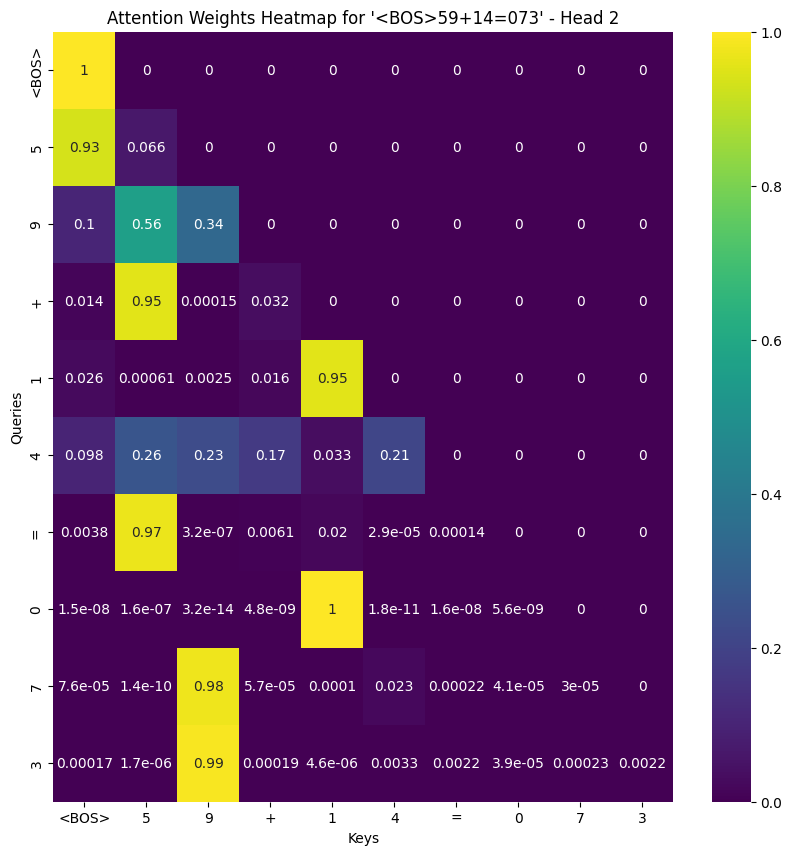

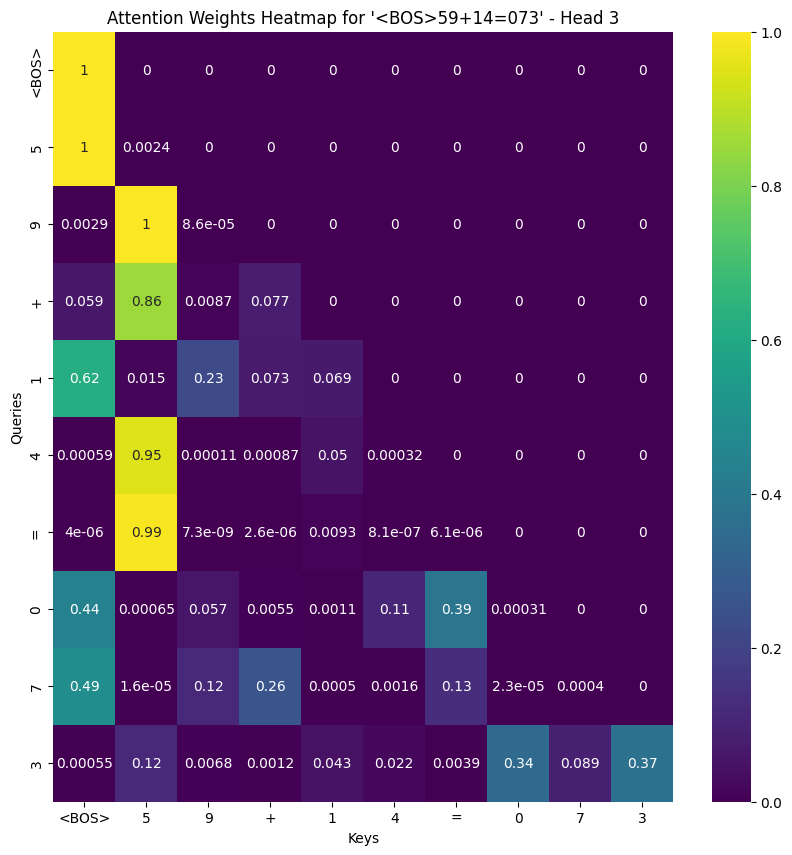

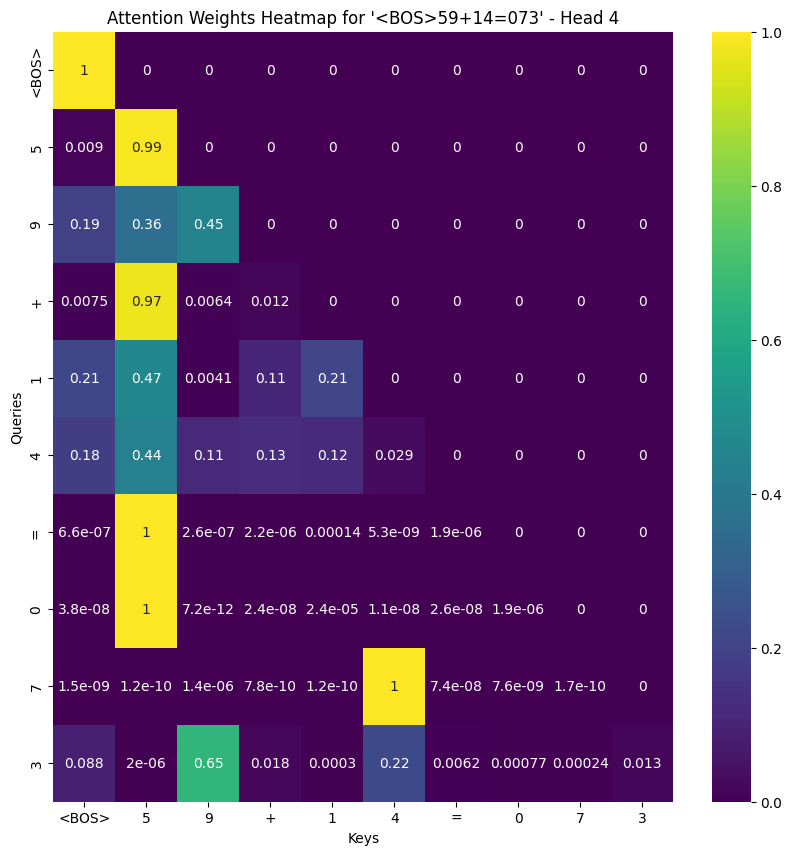

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing setup
last_decoder_block = trained_model.decoder_blocks[-1]
masked_self_attention_mha = last_decoder_block.masked_self_attention_mha
context_vector, attention_weights = masked_self_attention_mha.context_vector, masked_self_attention_mha.attention_weights

# Number of heads
num_heads = attention_weights.size(1)

# Labels for each character in the sequence, including BOS
labels = ['<BOS>'] + list('59+14=073')

# Loop over each head and plot its heatmap
for head in range(num_heads):
    plt.figure(figsize=(10, 10))

    # Extract attention weights for the last sample in the last batch for this head
    attention_matrix = attention_weights[-1, head, :, :].numpy()

    sns.heatmap(attention_matrix, annot=True, cmap='viridis', xticklabels=labels, yticklabels=labels)
    plt.title(f"Attention Weights Heatmap for '<BOS>59+14=073' - Head {head+1}")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()


## DEBUG

### W


```
Epoch 1/2
----------
100%|██████████| 28/28 [00:04<00:00,  5.91it/s]
100%|██████████| 8/8 [00:00<00:00, 14.21it/s]
Training Loss   : 2.08882
Validation Loss : 1.27368
Epoch 2/2
----------
  7%|▋         | 2/28 [00:00<00:04,  5.68it/s]
100%|██████████| 28/28 [00:04<00:00,  6.42it/s]
100%|██████████| 8/8 [00:00<00:00, 21.24it/s]
Training Loss   : 1.23194
Validation Loss : 1.10291
Training complete
```

CHANGED EOS and BOS SWAP POSITION

```
Epoch 1/2
----------
 32%|███▏      | 9/28 [00:01<00:02,  6.90it/s]
100%|██████████| 28/28 [00:03<00:00,  8.22it/s]
100%|██████████| 8/8 [00:00<00:00, 26.60it/s]
Training Loss   : 2.10450
Validation Loss : 1.28284
Epoch 2/2
----------
100%|██████████| 28/28 [00:02<00:00,  9.82it/s]
100%|██████████| 8/8 [00:00<00:00, 25.31it/s]
Training Loss   : 1.23119
Validation Loss : 1.09374
```

### M 

```
Epoch 1/2
----------
100%|██████████| 28/28 [00:02<00:00, 13.63it/s]
100%|██████████| 8/8 [00:00<00:00, 34.32it/s]
Training Loss   : 2.08863
Validation Loss : 1.26961
Epoch 2/2
----------
100%|██████████| 28/28 [00:01<00:00, 14.40it/s]
100%|██████████| 8/8 [00:00<00:00, 44.49it/s]
Training Loss   : 1.23620
Validation Loss : 1.11484
Training complete

---

Epoch 29/30
----------
100%|██████████| 28/28 [00:01<00:00, 15.37it/s]
100%|██████████| 8/8 [00:00<00:00, 41.86it/s]
Training Loss   : 0.01514
Validation Loss : 0.00067
Epoch 30/30
----------
100%|██████████| 28/28 [00:01<00:00, 15.38it/s]
100%|██████████| 8/8 [00:00<00:00, 42.62it/s]
Training Loss   : 0.01448
Validation Loss : 0.00057
Training complete
```

```
Epoch 1/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.22it/s]
100%|██████████| 8/8 [00:00<00:00, 29.15it/s]
Training Loss   : 2.10712
Validation Loss : 1.27872
Epoch 2/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.78it/s]
100%|██████████| 8/8 [00:00<00:00, 29.36it/s]
Training Loss   : 1.23133
Validation Loss : 1.09508
Epoch 3/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.91it/s]
100%|██████████| 8/8 [00:00<00:00, 29.92it/s]
Training Loss   : 1.03519
Validation Loss : 0.87629
Epoch 4/30
----------
100%|██████████| 28/28 [00:02<00:00, 13.41it/s]
100%|██████████| 8/8 [00:00<00:00, 28.30it/s]
Training Loss   : 0.87725
Validation Loss : 0.78361
Epoch 5/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.86it/s]
100%|██████████| 8/8 [00:00<00:00, 30.18it/s]
Training Loss   : 0.79957
Validation Loss : 0.73302
Epoch 6/30
----------
100%|██████████| 28/28 [00:02<00:00, 13.35it/s]
100%|██████████| 8/8 [00:00<00:00, 28.31it/s]
Training Loss   : 0.76029
Validation Loss : 0.69880
Epoch 7/30
----------
100%|██████████| 28/28 [00:02<00:00, 13.45it/s]
100%|██████████| 8/8 [00:00<00:00, 30.39it/s]
Training Loss   : 0.72721
Validation Loss : 0.68126
Epoch 8/30
----------
100%|██████████| 28/28 [00:02<00:00, 13.53it/s]
100%|██████████| 8/8 [00:00<00:00, 27.81it/s]
Training Loss   : 0.70416
Validation Loss : 0.63668
Epoch 9/30
----------
100%|██████████| 28/28 [00:02<00:00, 13.25it/s]
100%|██████████| 8/8 [00:00<00:00, 29.87it/s]
Training Loss   : 0.64809
Validation Loss : 0.48974
Epoch 10/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.47it/s]
100%|██████████| 8/8 [00:00<00:00, 22.07it/s]
Training Loss   : 0.39999
Validation Loss : 0.16127
Epoch 11/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.28it/s]
100%|██████████| 8/8 [00:00<00:00, 29.57it/s]
Training Loss   : 0.20621
Validation Loss : 0.08199
Epoch 12/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.71it/s]
100%|██████████| 8/8 [00:00<00:00, 15.80it/s]
Training Loss   : 0.13922
Validation Loss : 0.05043
Epoch 13/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.76it/s]
100%|██████████| 8/8 [00:00<00:00, 29.94it/s]
Training Loss   : 0.11169
Validation Loss : 0.03682
Epoch 14/30
----------
100%|██████████| 28/28 [00:02<00:00, 13.03it/s]
100%|██████████| 8/8 [00:00<00:00, 30.37it/s]
Training Loss   : 0.08848
Validation Loss : 0.02700
Epoch 15/30
----------
100%|██████████| 28/28 [00:02<00:00, 13.33it/s]
100%|██████████| 8/8 [00:00<00:00, 30.22it/s]
Training Loss   : 0.07917
Validation Loss : 0.02183
Epoch 16/30
----------
100%|██████████| 28/28 [00:02<00:00, 13.20it/s]
100%|██████████| 8/8 [00:00<00:00, 27.96it/s]
Training Loss   : 0.06974
Validation Loss : 0.01599
Epoch 17/30
----------
100%|██████████| 28/28 [00:02<00:00, 11.07it/s]
100%|██████████| 8/8 [00:00<00:00, 30.04it/s]
Training Loss   : 0.05679
Validation Loss : 0.01285
Epoch 18/30
----------
100%|██████████| 28/28 [00:02<00:00, 11.82it/s]
100%|██████████| 8/8 [00:00<00:00, 18.65it/s]
Training Loss   : 0.04896
Validation Loss : 0.00878
Epoch 19/30
----------
100%|██████████| 28/28 [00:03<00:00,  9.00it/s]
100%|██████████| 8/8 [00:00<00:00, 26.38it/s]
Training Loss   : 0.04387
Validation Loss : 0.00921
Epoch 20/30
----------
100%|██████████| 28/28 [00:02<00:00,  9.98it/s]
100%|██████████| 8/8 [00:00<00:00, 28.77it/s]
Training Loss   : 0.04160
Validation Loss : 0.00447
Epoch 21/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.33it/s]
100%|██████████| 8/8 [00:00<00:00, 28.80it/s]
Training Loss   : 0.03468
Validation Loss : 0.00423
Epoch 22/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.97it/s]
100%|██████████| 8/8 [00:00<00:00, 29.11it/s]
Training Loss   : 0.03085
Validation Loss : 0.00279
Epoch 23/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.41it/s]
100%|██████████| 8/8 [00:00<00:00, 27.02it/s]
Training Loss   : 0.02741
Validation Loss : 0.00197
Epoch 24/30
----------
100%|██████████| 28/28 [00:02<00:00, 13.09it/s]
100%|██████████| 8/8 [00:00<00:00, 29.83it/s]
Training Loss   : 0.02015
Validation Loss : 0.00132
Epoch 25/30
----------
100%|██████████| 28/28 [00:02<00:00, 13.08it/s]
100%|██████████| 8/8 [00:00<00:00, 29.30it/s]
Training Loss   : 0.01844
Validation Loss : 0.00229
Epoch 26/30
----------
100%|██████████| 28/28 [00:02<00:00, 13.23it/s]
100%|██████████| 8/8 [00:00<00:00, 29.35it/s]
Training Loss   : 0.01913
Validation Loss : 0.00103
Epoch 27/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.50it/s]
100%|██████████| 8/8 [00:00<00:00, 27.89it/s]
Training Loss   : 0.01545
Validation Loss : 0.00076
Epoch 28/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.30it/s]
100%|██████████| 8/8 [00:00<00:00, 26.09it/s]
Training Loss   : 0.01616
Validation Loss : 0.00104
Epoch 29/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.28it/s]
100%|██████████| 8/8 [00:00<00:00, 25.84it/s]
Training Loss   : 0.01504
Validation Loss : 0.00092
Epoch 30/30
----------
100%|██████████| 28/28 [00:02<00:00, 12.59it/s]
100%|██████████| 8/8 [00:00<00:00, 25.87it/s]
Training Loss   : 0.01006
Validation Loss : 0.00047
Training complete
```

In [79]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

```
x -> tensor([[15,  9,  8, 10,  3,  5, 13]])
future_mask -> 7x7
tensor([[ True, False, False, False, False, False, False],
│   │   [ True,  True, False, False, False, False, False],
│   │   [ True,  True,  True, False, False, False, False],
│   │   [ True,  True,  True,  True, False, False, False],
│   │   [ True,  True,  True,  True,  True, False, False],
│   │   [ True,  True,  True,  True,  True,  True, False],
│   │   [ True,  True,  True,  True,  True,  True,  True]])

logits--> 1x7x18 because 1 sample
tensor([[[  7.8,  -0.2,  -2.3,  -1.1,  -0.1,  -3.2,  -4.4,
          -2.4,   3.7,  -0.9,  -5.1,  -4.5,  -5.6,  -2.2,
          -0.5,  -4.2,  -2.9,  -4.9],
        [  0.3,   3.7,   0.9,   1.7,   0.4,  -4.0,  -6.0,
          -2.3,   8.5,   7.3,  -6.0,  -5.1,  -6.2,  -3.0,
         -10.9,  -3.8,  -5.3,  -5.9],
        [-10.5,  -0.4,   4.3,   2.4,  -6.3,  -8.9,  -0.1,
           8.2,   8.6,   0.4,   1.2,   0.9,   0.7,   0.6,
           6.9,   0.0,   0.4,   1.2],
        [ -2.8,   9.6,   2.0,  -6.2,  -8.2,  -2.3,   5.7,
           6.6,  -0.3,  -4.7,  -0.5,  -0.9,  -0.9,   1.2,
           2.3,  -0.4,   0.1,  -1.5],
        [ -2.9,   1.6,  -1.0,  -5.8,  -0.2,   6.2,  14.1,
           8.0,  -4.0,  -9.7,  -2.1,  -3.4,  -3.2,  -1.4,
           0.0,  -1.7,   0.0,  -3.0],
        [ -9.4,   1.7,   5.4,  -1.3,  -6.6,  -4.7,   6.7,
          10.2,   1.9,  -9.6,   0.8,   0.6,   0.7,   1.2,
          10.2,   0.4,   1.3,   1.2],
        [  0.3,  16.1,   3.2,  -4.4,  -5.7,  -2.9,  -3.7,
          -6.1,  -2.1,   4.0,  -0.4,   0.1,  -0.4,   0.0,
           0.6,  -0.6,  -1.2,  -0.7]]])

logits.argmax(dim=-1) -> 1x7
tensor([[0,  8,  8,  1,  6, 14,  1]])
```

`logits.argmax(dim=-1)` basically compress 1x7x18 to 1x7 where for each row of the
7 rows, find the index that is maximum for example, first row 7.8 is max of all
18 elements, so index 0 is returned. `tensor([[0,  8,  8,  1,  6, 14,  1]])`

There is some meaning here too, remember our input `[15, 9, 8, 10, 3, 5, 13]`
this is basically the BOS (15) up till the equal sign, then
`[ 0, 8, 8, 1, 6, 14, 1]` is basically the prediction of each token what comes
next.

1. **Input Sequence**: Your input sequence is `[15, 9, 8, 10, 3, 5, 13]`. In
   this context, `15` could be a special token like BOS (Beginning of Sentence)
   or something else depending on your encoding scheme.

2. **Output Tensor Interpretation**: The output tensor
   `tensor([[ 0, 8, 8, 1, 6, 14, 1]])` represents the model's sequential
   predictions for each step of the input:

   - The first element `0` is the prediction following the first element `15` of
     the input.
   - The second element `8` is the prediction after seeing the first two
     elements `15, 9` of the input.
   - The third element `8` is predicted after seeing `15, 9, 8`.
   - The fourth element `1` follows after `15, 9, 8, 10`.
   - The sequence continues in this manner, with each new prediction based on an
     increasingly longer prefix of the input sequence.

3. **Sequential Predictions**: This output suggests that the model is working in
   an autoregressive manner. It generates predictions one token at a time, and
   each prediction is based on the sequence of tokens it has seen up to that
   point.

4. **Specific Meanings of Output Tokens**: The actual meaning of each token in
   your output tensor (`0`, `8`, `1`, `6`, `14`, etc.) depends on your specific
   encoding and task. In a language model, these would correspond to specific
   words or characters. In a numerical context, they could represent numbers or
   operations.

In summary, the output tensor reflects the model's predictions for what comes
next in the sequence, based on the current and all previous input tokens. Each
element in the output is the model's guess for the next token, considering the
sequence of tokens it has seen up to that point.

> Then we move on to the concat operation:


- In our model, after processing the input `[15, 9, 8, 10, 3, 5, 13]`, it
  predicts the next token to be `1`. This prediction is based on the entire
  sequence seen so far.

- The process of extending the input sequence with this new token (`1`) and then
  feeding this extended sequence back into the model for further predictions is
  indeed an example of greedy decoding. The model is iteratively building a
  longer sequence, one token at a time, always choosing the most likely next
  token at each step.

- This process would continue until a stopping condition is met, which might be
  the prediction of an EOS (End of Sentence) token or reaching a maximum
  sequence length.


> for i in range(num_digits + 2):
> now you know why loop over 4 times in total if num digits is 2.
> This is because, after equal sign, we will have answer of 3 digits (xyz)
> and an EOS token, our stop condition!

Lastly: `tensor([[15,  9,  8, 10,  3,  5, 13,  1,  3,  3, 14]])` is the full predicted
after EOS is met. 


In [ ]:
config.global_.seed = 42

In [82]:
def construct_future_mask(seq_len: int) -> torch.BoolTensor:
    future_mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=1).to(torch.bool)
    future_mask = future_mask.contiguous()
    future_mask = future_mask == 0
    return torch.BoolTensor(future_mask)

def construct_padding_mask(input_sequence: torch.Tensor, pad_token_id: int) -> torch.BoolTensor:
    padding_mask = input_sequence != pad_token_id
    return torch.BoolTensor(padding_mask)

In [85]:
@torch.no_grad()
def compute_sum(model, x) -> List[int]:
    "Function for computing the sum of two numbers."
    # x=[[15,  9,  8, 10,  3,  5, 13]]
    for _ in range(num_digits + 2):
        # pprint(x)
        pad_mask = (x != PAD).view(1, 1, 1, x.size(-1)).to(DEVICE)
        future_mask = construct_future_mask(seq_len=x.size(1))
        batch_size, seq_len = x.size()
        future_mask = future_mask.view(1, seq_len, seq_len).expand(size=(batch_size, -1, -1)).unsqueeze(1)
        #print(pad_mask.shape, future_mask.shape)
        #inputs, targets, target_padding_masks, future_masks = construct_batches(x)
        #print(target_padding_masks.shape, future_masks.shape)
        logits = model(input_tokens=x, target_padding_masks=pad_mask, future_masks=future_mask)
        pprint(logits.shape)
        time.sleep(100)
        #logits = model(inputs, target_padding_masks=target_padding_masks, future_masks=future_masks)

        last_output = logits.argmax(-1)[:, -1].view(1, 1)
        x = torch.cat((x, last_output), 1).to(DEVICE)
        # STOPPING CONDITION!
        if last_output.item() == EOS:
            break
        #return
    return x[0]


def evaluate(model, dataloader, num_batch=None):
    """
    Function for evaluation the model.

    This function take equations, and truncate them up to the equal-sign, and feed
    them to the model to get the predictions, compare them with the correct answers,
    and output the accuracy.
    """
    model.eval()
    acc, count = 0, 0
    num_wrong_to_display = 5
    for idx, batch in enumerate(dataloader):
        (
            inputs,
            targets,
            target_padding_masks,
            future_masks,
        ) = batch  # construct_batches(batch)
        for equation in inputs:
            # pprint(equation)
            # add EOS behind equation
            equation = torch.cat((equation, torch.tensor([EOS])), 0) # TODO: PLEASE DO NOT DO THIS - DO NOT MODIFY LIKE THIS.
            # fmt: off
            loc_equal_sign = equation.tolist().index(EQUAL)
            loc_EOS        = equation.tolist().index(EOS)
            input          = equation[0 : loc_equal_sign + 1].view(1, -1).to(DEVICE)
            ans            = equation[: loc_EOS + 1].tolist()
            ans_pred       = compute_sum(model, input)
            count += 1
            # fmt: on

            if ans == ans_pred.tolist():
                acc += 1
            else:
                if num_wrong_to_display > 0:
                    print(
                        f'correct equation: {decode_equation(vocab=vocab, equation=equation).replace("<PAD>","")}'
                    )
                    print(f"wrongly predicted as:        {decode_equation(vocab=vocab, equation=ans_pred)}")
                    num_wrong_to_display -= 1
        if num_batch and idx > num_batch:
            break
    return acc / count


def what_is(question: str) -> str:
    "function for computing the sum of two numbers with input in literal string format"
    pred = compute_sum(model, encode_equation(question, num_digits).view(1, -1))
    pred = decode_equation(pred)
    pred = pred[pred.index("=") + 1 :]
    return question + pred


The provided code implements a form of greedy decoding for sequence generation.
Let's break down how it aligns with the principles of greedy decoding:

1. **Greedy Decoding Principle**: Greedy decoding in sequence generation models
   involves choosing the most probable next token at each step of the sequence
   generation. This is done iteratively until a stopping condition is met (like
   reaching an EOS token or a maximum length).

2. **Implementation in Your Code**:

   - The `compute_sum` function generates a sequence by repeatedly predicting
     the next token and appending it to the input.
   - For each iteration in `compute_sum`:
     - The model (`model(x, pad_mask, future_mask)`) generates logits for the
       next token based on the current sequence (`x`).
     - `last_output = logits.argmax(-1)[:, -1].view(1, 1)` picks the most
       probable next token (the token with the highest logit value) from the
       logits. This is the essence of greedy decoding.
     - This token is then appended to the sequence:
       `x = torch.cat((x, last_output), 1)`.
   - The process continues until the model generates an EOS token, as indicated
     by `if last_output.item() == EOS: break`.

3. **Evaluation Function**:

   - The `evaluate` function further confirms this approach by feeding truncated
     sequences (up to the equal sign) from the dataloader to the `compute_sum`
     function and comparing the model's predictions to the correct answers.

4. **Characteristics of Greedy Decoding**:
   - Greedy decoding is computationally efficient and straightforward but may
     not always produce the best possible sequence. It does not reconsider past
     decisions; it always picks the most likely next token at each step without
     considering the global context of the sequence.

In summary, the provided code, especially the `compute_sum` function, implements
a typical greedy decoding approach. It iteratively generates a sequence by
choosing the most probable next token at each step, which is characteristic of
greedy decoding in sequence generation tasks.


In [86]:
print('training set examples the model gives an incorrect result:')
# rng = torch.Generator().manual_seed(config.global_.seed)
seed_all(1992, seed_torch=True)

train_acc = evaluate(model, train_loader, 2)
pprint(train_acc) #
# print('validataion set examples the model gives an incorrect result:')
val_acc = evaluate(model, val_loader)
pprint(val_acc)
# print('test set examples the model gives an incorrect result:')
test_acc = evaluate(model, test_loader)
pprint(test_acc)
# result = f'''train_size: {train_size}, test_acc: {test_acc}, val_acc: {val_acc}, train_acc: {train_acc}
#                 '''
# print(result)

training set examples the model gives an incorrect result:


/Users/gaohn/gaohn/omniverse/omnivault/transformer/utils/reproducibility.py:69: UserWarning: Deterministic mode is activated. This will negatively impact performance.
  configure_deterministic_mode()
/Users/gaohn/gaohn/omniverse/omnivault/transformer/decoder/core.py:214: UserWarning: An output with one or more elements was resized since it had shape [1, 1, 1, 7], which does not match the required output shape [1, 1, 7, 7]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  torch.logical_and(cast(torch.Tensor, target_padding_masks), cast(torch.Tensor, future_masks)).bool(),


torch.Size([1, 7, 18])

KeyboardInterrupt: 

QUESTION:

another not so smart question of the day: For an input sequence x1,x2,...,x_L, when it forward pass all the way through the decoder model, up till before the pre-logits/head/linear layer, and assuming for simplicity that we squeeze out the first batch dimension (only 1 sample), the the shape of the pre-logits is [L, D] where L is seq len and D the hidden embedding dimension. Am I right to say that the last row of [L, D] being the last token's representation, holds info of the full context of all previous tokens.

1. This means the last token in the input sequence (the last row in [L, D]) is a function of all previous tokens, so it is not surprising why the tutorial will just use the last row/token's corresponding prediction as the next predicted token/word, given all previous tokens.

> Important to know the last token or last row of [L, D] is actually a function of all previous tokens, here it is unmasked already.
> So if confused, just remember the pre logits last row, corresponding to the last token in the input sequence, is a function of all previous tokens.
> It just means that row holds all information, context, of all previous tokens so we can say its conditioned on all previous tokens.

train acc: 0.021484375 , 0.0185546875

non debug

```
correct equation: 24+86=110
predicted:        24+86=100
correct equation: 84+26=110
predicted:        84+26=100
validataion set examples the model gives an incorrect result:
test set examples the model gives an incorrect result:
train_size: 7000, train_loss: 0.013642309483007662,
                val_loss: 0.0008140208410623018, test_loss: 0.00040599027124699205,
                test_acc: 1.0, val_acc: 1.0, train_acc: 0.9996448863636364
```

## <a id='toc1_10_'></a>[Adder Decoder Walkthrough](#toc0_)

In a decoder-only model like GPT, the input sequence is essentially the target.
The model aims to generate tokens that come after the given input, treating it
as the "history" or "context" for the task of text generation. Unlike
encoder-decoder models like the original Transformer, where the encoder
processes a source sequence and the decoder generates a target sequence, a
decoder-only model works solely with what would traditionally be considered the
target sequence. Therefore, the padding mask applied to this input sequence is
more aptly named "target_padding_mask" to maintain terminological consistency
with the original Transformer architecture.

Consequently, the input (source to beginners like me) padding masks is called
the target padding masks for the following reasons:

In a decoder-only architecture like GPT, the input sequence serves as the target
sequence for which you want to generate subsequent tokens. Despite its role as
an input to the model, it's termed as "target" because in the original
Transformer architecture, the decoder's job is to generate the target sequence.
Therefore, the mask that works on this input sequence in a decoder-only model
should more aptly be named "target_padding_mask." This naming maintains
consistency with the Transformer architecture and clarifies that you're working
on what is essentially the target of the model's generation task.

### <a id='toc1_10_1_'></a>[Target Padding Mask (`target_padding_mask`)](#toc0_)

- Definition: An attention mask to ignore pad-tokens in the source input. But in decoder only model, the source is the target.
- Shape     : `(B, S)` or `(B, L)`.

In [ ]:
pad_token_id = 16
target_batch = torch.tensor(
    [
        [5, 7, 9, 16, 16],
        [8, 6, 16, 16, 16],
        [3, 12, 4, 11, 16],
        [2, 1, 4, 16, 16],
    ]
)

batch_size, seq_len = target_batch.size()

target_padding_mask = target_batch != pad_token_id

pprint(target_padding_mask)
pprint(target_padding_mask.shape)

### <a id='toc1_10_2_'></a>[Future Mask (`future_mask`)](#toc0_)

```
:param future_mask:
:shape            : (L, L)
:note             : Independent of batch size?
```

In [ ]:
seq_len = 5
future_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
future_mask = future_mask == 0

pprint(future_mask)
pprint(future_mask.shape)

One thing we need to know is that we need to do a matmul of `attention_weights` (emphasize the weights word here because it is indeed derived
from weights although not explicit) and the value (the input seq). This attention weights has a preceding
`attention_scores` prior to softmax, and we need to fill the tensors in this `attention_scores` with `-inf` because
the softmax operation on `-inf` is zero, effectively zero out masked logits.

Let's consider what zeroing out these masked logits actually does. The attention
mechanism can be thought of as a weighted average of all the tokens in the input
sequence. Each token is assigned a weight, with higher weights indicating more
relevance to the token under consideration. If a certain token should not be
considered at all (e.g., it's a future token that should not be visible to the
current decoder step, or it's a padding token), its weight should be zero.

In the case of a masked self-attention mechanism, as is often used in the
decoder of a transformer, there are two main scenarios where masking comes into
play:

1. **Padding Tokens**: You don't want the attention mechanism to consider
   padding tokens as they carry no useful information. If it did, it could skew
   the resulting weighted average.

2. **Future Tokens in Decoding**: In autoregressive decoding, the model
   shouldn't have access to future tokens in the sequence when making
   predictions. Otherwise, the model would cheat by peeking ahead.

By setting the corresponding positions in the attention scores tensor to `-inf`
and then applying a softmax, you effectively get a zero at those positions in
the attention weights tensor. This results in completely ignoring those tokens
when taking the weighted sum of the value vectors, thus implementing the desired
masking behavior.

To summarize, zeroing out masked logits ensures that the tokens corresponding to
those logits do not contribute to the computed context, whether because they are
padding or because they are future tokens that should not be visible to the
model at a given time step.


The purpose of applying `logical_and` between `target_padding_mask` and `future_mask` is to combine the constraints from both masks when calculating self-attention scores in the transformer's decoder. The `target_padding_mask` is designed to mask out the padding tokens in the input sequence, while the `future_mask` ensures that a given position cannot attend to future positions in the sequence. By combining these masks, you can perform the necessary masking for both padding and future tokens in a single step.

Here's how it works:

1. `target_padding_mask`: Masks out the padding tokens so that they don't contribute to the attention calculations. True values mean "attend to this token," and False values mean "ignore this token."
  
2. `future_mask`: The future mask is created as a lower triangular matrix, where the lower triangle, including the diagonal, is filled with ones, and the upper triangle is filled with zeros. Masks out future tokens in a sequence so that a token at a given position can only attend to positions that come before it (and itself). True values mean "attend to this token," and False values mean "ignore this token."

3. `logical_and(target_padding_mask, future_mask)`: Combines the two masks. A True in the resulting mask means that the condition for both padding and future attention is satisfied.

By combining these two masks, the decoder obeys the autoregressive property, ensuring it doesn't see future tokens, while also ignoring padding tokens in the input sequence. We may term it the `target_mask`?

Same mask applied to all h heads.
Same mask applied to all h heads.
Same mask applied to all h heads.



### <a id='toc1_10_3_'></a>[Example of Source Padding and Future Masks](#toc0_)

#### <a id='toc1_10_3_1_'></a>[First Sample First Token](#toc0_)

- `target_padding_mask` has size of `[4, 5]`.
  - We zoom in to the first row (sample) which is of length 5.
  - This length 5 is the sequence length, which is `T, T, T, F, F` indicating the last 2 tokens being padded.
- `future_mask` has size of `[5, 5]`.
  - We note that this is indepedent of batch size. Each sample should have the same future mask shape of `[L, L]`.
  - This `L=5` should necessary be same for the sequence length in `target_padding_mask`.
- First, let's consider one batch of 4 samples. What we do first is to broadcast `future_mask` to `[4, 5, 5]` because we want each sample/row in the batch to have the same future mask. As shown below:

In [ ]:
pprint(future_mask)
future_mask = future_mask.view(1, seq_len, seq_len).expand(size=(batch_size, -1, -1))
pprint(future_mask)
pprint(future_mask.shape)

- Now, we can zoom in to one particular sample since both `target_padding_mask` and `future_mask` have the same first dimension of batch size.
- What is incomplete is that we need to broadcast `target_padding_mask`'s last dimension to have the same dimensions as `future_mask`. This means we broadcast `[4, 5]` to `[4, 5, 5]`. But why?
- For simplicity, we slice the first same of both below.
- The first row of the `future_mask` of the first sample is `T, F, F, F, F`. This corresponds to what? This is the future mask of the first token in the sequence. Well, that is confusing, because it apparently have 5 elements, and has "information" of the other 4 tokens in the sequence. Let's explain in details below:
  - Regarding the first row of the `future_mask` in the first sample, which is `[T, F, F, F, F]`, it might initially seem confusing why there are 5 elements. Each of these elements, in fact, corresponds to whether the first token can attend to other tokens at each respective position in the sequence. Here's how to interpret it:
    - The first element (`True`) indicates that the first token can attend to itself.
    - The next four elements (`False`) specify that the first token should not attend to any of the future tokens in the sequence.
- Consequently, what is the first token in the sequence of the `target_padding_mask`? Recall earlier we mentioned that the first sample's `target_padding_mask` is `T, T, T, F, F` and therefore the first token in the sequence is `T`.
- What do we want to achieve here? We want to make sure that the model does not **attend** to tokens in the sequence that are masked with `False`.
- In other words, the first token in the sequence of the first sample has `target_padding_mask` of `T` and `future_masks` of `T, F, F, F, F`.
- We need to broadcast this `T` to `T, T, T, T, T` to align with `T, F, F, F, F` because? Because we need ensure that this first token in the sequence is also able to considered in relation to every other token in the sequence.
- So the first token is not a padded token, which is `T`, similarly, the first token needs to attend to itself at the first position, hence `T` and `T` give `T`. But for the second `T` in the now broadcasted `target_padding_mask`, it is still representing the first token or?
- Broadcasting the first token's `target_padding_mask` value of `T` to `[T, T, T, T, T]` ensures that when this first token is being considered for attention computations, it is free to attend to any position, barring any restrictions set by `future_mask`.
- Tricky: after broadcasting, each `T` in `[T, T, T, T, T]` is still representing the first token. They indicate that when the first token is compared with *any* token in the sequence (including itself), it is not a padding token. The element-wise `AND` with the `future_mask` then further refines this by restricting it from attending to future tokens.

In [ ]:
pprint(target_padding_mask)
pprint(target_padding_mask[0])

In [ ]:
pprint(target_padding_mask)
target_padding_mask = target_padding_mask.view(batch_size, 1, seq_len).expand(size=(batch_size, seq_len, seq_len))
pprint(target_padding_mask)
pprint(target_padding_mask.shape)

In [ ]:
pprint(target_padding_mask[0])
pprint(future_mask[0])
pprint(target_padding_mask[0] & future_mask[0])

#### <a id='toc1_10_3_2_'></a>[First Sample Fourth Token](#toc0_)

Now let's look at another example—the 4th token in the sequence, where `target_padding_mask = [T, T, T, F, F]` and `future_mask` is a lower triangular matrix with `True`s.

1. **4th Token's target_padding_mask**: The 4th token has a value of `F` in `target_padding_mask`, indicating it's a padding token.
   
2. **4th Row of future_mask**: The 4th row in `future_mask` is `[True, True, True, True, False]`. This means that if this token were not a padding token, it would be allowed to attend to all the previous tokens in the sequence and itself, but not to any future token.

3. **Broadcast target_padding_mask**: To align `target_padding_mask` with `future_mask`, we'd broadcast `F` from the `target_padding_mask` to `[F, F, F, F, F]`. This way, when we consider the 4th token in relation to any other token in the sequence, it's still marked as a padding token.

4. **Element-wise AND with future_mask**: After broadcasting, you'd perform an element-wise AND between `[F, F, F, F, F]` and `[True, True, True, True, False]`, resulting in `[F, F, F, F, F]`.

5. **Interpretation**: This effectively means that the 4th token won't attend to any other token in the sequence, and no token will attend to it either, as it is a padding token.

So, the masks are doing their jobs correctly: the `target_padding_mask` indicates whether each token is a padding token or not, and `future_mask` dictates the "rules" of attention regarding what each token can attend to. Combining them ensures that both conditions are met.

### <a id='toc1_10_4_'></a>[Further Add a Singleton Dimension in Masks](#toc0_)

Now both masks are of shape: `(B, L, L)` but we need to add a singleton dimension to the last dimension to make it `(B, 1, L, L)`.

In deep learning frameworks like PyTorch, the dimensions of the tensors involved
in operations like matrix multiplication or attention mechanisms often have
specific semantic meanings. In the context of attention mechanisms, especially
in the transformer architecture, the attention mask usually has a shape that is
compatible with the attention logits for element-wise multiplication.

In the transformer model, the attention logits are often computed as a dot
product between query and key vectors, resulting in a tensor of shape
`(Batch size, Num heads, Sequence length, Sequence length)` or `(B, H, L, L)`.
Here, `B` is the batch size, `H` is the number of attention heads, and `L` is
the sequence length.

To make the mask tensor compatible for element-wise operations with this 4D
tensor, it needs to have a shape that can be broadcasted to `(B, H, L, L)`. A
mask of shape `(B, 1, L, L)` fulfills this requirement.

The singleton dimension is added so that the mask can be easily broadcast to the
shape of the attention logits tensor during the computation. When a tensor with
shape `(B, 1, L, L)` is element-wise multiplied with a tensor of shape
`(B, H, L, L)`, the singleton dimension (the `1`) allows the mask to be used for
each attention head without explicitly replicating the mask `H` times. This is
more memory-efficient and often faster.

Thus, adding a singleton dimension in masks is a preparatory step that allows
for efficient element-wise operations later in the model's forward pass.


In [ ]:
target_padding_mask = target_padding_mask.unsqueeze(1)
pprint(target_padding_mask.shape)

future_mask = future_mask.unsqueeze(1)
pprint(future_mask.shape)

target_mask = target_padding_mask & future_mask
pprint(target_mask.shape)

### <a id='toc1_10_5_'></a>[MultiHeadAttention](#toc0_)

We start off by understanding the rationale of the following block:

```python
Q = self.W_Q(query).contiguous() # Z @ W_Q -> BxLxD @ DxD = BxLxD
K = self.W_K(key).contiguous()   # Z @ W_K
V = self.W_V(value).contiguous() # Z @ W_V
```

#### <a id='toc1_10_5_1_'></a>[A Primer](#toc0_)

In the context of the Transformer architecture and self-attention mechanism, the
matrices $\mathbf{W}^{Q}, \mathbf{W}^{K},$ and $\mathbf{W}^{V}$ are learnable
parameters designed to project the input embeddings $\mathbf{Z}$ into distinct
subspaces tailored for attention calculations. Let's explore their purpose and
their resulting transformations:

1. **The Role of Weights**:

   - $\mathbf{W}^{Q}$: Projects input embeddings into a query subspace,
     determining the type of information each token seeks from others.
   - $\mathbf{W}^{K}$: Positions the embeddings in a key subspace, highlighting
     the token features that others would search for.
   - $\mathbf{W}^{V}$: Transforms embeddings into a value subspace, showcasing
     the actual token content to be aggregated by the attention scores.

2. **Intuitive & Mathematical Interpretations**:

   - **Query Transformation** ($\mathbf{Z} \mathbf{W}^{Q}$): Intuitively, it
     tailors the raw embeddings to optimally question the rest of the sequence.
     Mathematically, it's a linear transformation of the embedding space into
     the query space, akin to a high-dimensional rotation and scaling,
     emphasizing aspects relevant to querying.

   - **Key Transformation** ($\mathbf{Z} \mathbf{W}^{K}$): Intuitively, it
     accentuates token features that other tokens might seek. Mathematically,
     it's another linear transformation emphasizing aspects that make tokens
     searchable.

   - **Value Transformation** ($\mathbf{Z} \mathbf{W}^{V}$): Intuitively, it
     prepares tokens to share their intrinsic content when beckoned by the
     attention mechanism. Mathematically, it's a linear transformation
     accentuating token content aspects.

3. **Creating Q, K, V**:

   - $\mathbf{Q} = \mathbf{Z} \mathbf{W}^{Q}$
   - $\mathbf{K} = \mathbf{Z} \mathbf{W}^{K}$
   - $\mathbf{V} = \mathbf{Z} \mathbf{W}^{V}$

   These operations recast the embedded tokens into roles for the attention
   mechanism:

   - $\mathbf{Q}$: Information seekers. The queries are seeking information, and
     the computation $Q @ K^T$ finds how much each part of the input (holder)
     should be attended to.
   - $\mathbf{K}$: Information gatekeepers. The keys hold the information being
     sought, and their arrangement in space defines the subspace that the
     queries are projected onto to find these relevance scores.
   - $\mathbf{V}$: Information providers. The values contain the content that
     needs to be retrieved, and once we have the attention weights, we know how
     much of each value to retrieve and combine to form the output.

   Mathematically, the resulting matrices ($\mathbf{Q}, \mathbf{K}, \mathbf{V}$)
   have rows that represent different aspects (querying, key, value) of the
   original tokens.

4. **Relevance to Self-Attention**:

   The transformations set the stage for attention score calculations. In this
   step, each query vector in $\mathbf{Q}$ computes its similarity (via dot
   product) against all key vectors in $\mathbf{K}$. This score matrix reveals
   the attention weightage for each token regarding every other token in the
   sequence.

   Specifically, $\mathbf{Q} @ \mathbf{K}^T$ calculates how each token (query)
   aligns with every other token (key). It's akin to measuring the relevance of
   each word to every other word in the sequence.

   After normalizing these scores (typically with softmax), we get the attention
   weights. These weights guide how the value vectors in $\mathbf{V}$ are
   aggregated. The outcome is a new matrix where each row aggregates
   contextually relevant information from the entire sequence. This enriched
   output feeds into subsequent transformer layers for further processing.

Overall, by using the $\mathbf{W}^{Q}, \mathbf{W}^{K},$ and $\mathbf{W}^{V}$
matrices, the transformer fine-tunes its focus on inter-token relationships,
enabling the model to capture intricate contextual nuances within a given
sequence.

#### <a id='toc1_10_5_2_'></a>[An Example](#toc0_)

Let's use the sentence "The cat walks by the bank" to walk through the
self-attention mechanism with analogies and to clarify how it works step by
step.

**Setting the Scene (Embedding the Sentence):** Imagine each word in the
sentence is a person at a party (our tokens). They start by telling a basic fact
about themselves (their initial embedding).

**The Roles:**

- **Q (Seekers)**: Each person (word) is curious about the stories (contexts) of
  others at the party. They have their own perspective or question (Q vector).
- **K (Holders)**: At the same time, each person has a name tag with keywords
  that describe their story (K vector).
- **V (Retrievers)**: They also hold a bag of their experiences (V vector),
  ready to share.

**Transformations (Applying W Matrices):** We give each person a set of glasses
(the matrices $W_Q, W_K, W_V$) that changes how they see the world (the space
they project to).

- With $W_Q$ glasses, they focus on what they want to know from others.
- With $W_K$ glasses, they highlight their name tag details, making some
  features stand out more.
- With $W_V$ glasses, they prepare to share the contents of their bag
  effectively.

**Attention (Calculating Q @ K.T):** Now, each person looks around the room
(sequence) with their $W_Q$ glasses and sees the highlighted name tags (after
$W_K$ transformation) of everyone else. They measure how similar their question
is to the others' name tags—this is the dot product $Q @ K^T$.

For "cat," let’s say it’s curious about the notion of "walking" and "bank." It
will measure the similarity (attention scores) between its curiosity and the
name tags of "walks," "by," "the," "bank."

**Normalization (Softmax):** After measuring, "cat" decides how much to focus on
each story—this is softmax. Some stories are very relevant ("walks"), some
moderately ("by," "the"), and some might be highly relevant depending on context
("bank" — is it a river bank or a financial institution?).

**Retrieval (Applying Attention to V):** Now "cat" decides to listen to the
stories in proportion to its focus. It takes pieces (weighted by attention
scores) from each person's experience bag (V vectors) and combines them into a
richer, contextual understanding of itself in the sentence. This combination
gives us the new representation of "cat," informed by the entire context of the
sentence.

In essence:

- **Q (Query):** What does "cat" want to know?
- **K (Key):** Who has relevant information to "cat"’s curiosity?
- **V (Value):** What stories does "cat" gather from others, and how much does
  it take from each to understand its role in the sentence?

The output of self-attention for "cat" now encapsulates not just "cat" but its
relationship and relevance to "walks," "by," "the," "bank" in a way that no
single word could convey alone. This output then becomes the input to the next
layer, where the process can repeat, enabling the model to develop an even more
nuanced understanding.

<img src="transformer.png" width="600">


### <a id='toc1_10_6_'></a>[AddNorm (Residual Connection + Layer Normalization)](#toc0_)

- https://www.d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#residual-connection-and-layer-normalization
- https://nlp.seas.harvard.edu/annotated-transformer

#### <a id='toc1_10_6_1_'></a>[Residual Block](#toc0_)

A residual block takes an input $X$ and a sub-layer (or function) $f$, and computes $X + f(X)$.

```python
class ResidualBlock(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(
        self,
        x: torch.Tensor,
        sublayer: Callable[[torch.Tensor], torch.Tensor],
    ) -> torch.Tensor:
        return x + sublayer(x)
```

The intuition behind a residual block is to facilitate the training of deeper networks by providing a "shortcut" or "skip connection" that allows the gradient to be directly backpropagated to earlier layers. Essentially, in a standard deep learning model, each layer transforms its input. As the network depth increases, these transformations can degrade the network's performance, mainly due to the vanishing or exploding gradient problems. This makes it challenging to train very deep networks.

The residual block aims to address this problem. It adds the original input back to the output of the network layer, forming $F(x) + x$ instead of just $F(x)$. Mathematically, if $x$ is the input and $F(x)$ is the transformed version, then the residual block computes $F(x) + x$.

This architecture has a few advantages:

1. **Easier Learning**: During training, if the best transformation is an identity map (i.e., the output should be the same as the input), the residual block can easily learn this. The layers in $F(x)$ only need to learn to approximate zero in this case, which is generally easier than learning an identity map in a traditional stack of layers.

2. **Mitigating Vanishing/Exploding Gradients**: The skip connections provide an unobstructed path for the gradients to flow, which can help mitigate the vanishing or exploding gradient problems in very deep networks.

3. **Enabling Deeper Networks**: Because of the above advantages, residual blocks make it possible to train very deep networks effectively. Deep networks can represent very complex functions, which can be advantageous for many tasks.

4. **Parameter Efficiency**: Residual blocks often require fewer parameters to achieve similar performance compared to traditional deep networks, making them more parameter-efficient.

In summary, the residual block is a simple yet effective idea that has enabled the training of much deeper networks, thereby pushing the boundaries of what is achievable in various machine learning tasks.

#### <a id='toc1_10_6_2_'></a>[Layer Normalization](#toc0_)

Layer normalization normalizes the features across the feature dimension. Given the feature $X$ with shape $[B, L, D]$ (where $B$ is the batch size, $L$ is the sequence length, and $D$ is the feature dimension), layer normalization computes:

$$
\text{Norm}(X) = \frac{X - \text{mean}(X)}{\sqrt{\text{var}(X) + \epsilon}} \times \gamma + \beta
$$

Where $\gamma$ and $\beta$ are learnable parameters and $\epsilon$ is a small constant for numerical stability.

```python
class LayerNorm(nn.Module):
    def __init__(self, feature_dim: int, eps: float = 1e-6) -> None:
        super().__init__()
        # fmt: off
        self.gamma = nn.Parameter(torch.ones(feature_dim))
        self.beta  = nn.Parameter(torch.zeros(feature_dim))
        self.eps   = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mean = x.mean(dim=-1, keepdim=True)
        std  = x.std(dim=-1, keepdim=True)
        # fmt: on
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
```

#### <a id='toc1_10_6_3_'></a>[Combining Both](#toc0_)

Finally, you can combine these into a single block, much like the `ResidualConnection` or `AddNorm` classes you mentioned earlier.

```python
class AddNorm(nn.Module):
    def __init__(self, feature_dim, dropout_rate):
        super(AddNorm, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = LayerNorm(feature_dim)

    def forward(self, x, sublayer_output):
        return self.layer_norm(x + self.dropout(sublayer_output))
```

This `AddNorm` class applies dropout to the output of the sub-layer, adds it to the original input, and then applies layer normalization. Note that this version doesn't include an embedded layer normalization operation in the residual block; instead, it utilizes a separate layer normalization class, which is then used in the `AddNorm` class.

### <a id='toc1_10_7_'></a>[How Loss is Computed?](#toc0_)

The unreduced loss for the Cross Entropy calculation is given by:

$$
\mathcal{L}(\mathcal{X}, \mathcal{Y}) = \{l_1, \ldots, l_N\}^\top, \quad l_n = -\mathcal{W}_{\mathcal{Y}_n} \cdot \log \left( \frac{\exp(\mathcal{X}_{n, \mathcal{Y}_n})}{\sum_{c=1}^\mathcal{C} \exp(\mathcal{X}_{n, c})} \right) \cdot \mathbb{1}\{\mathcal{Y}_n \neq \text{ignore\_index}\}
$$

where:

- $\mathcal{X}$ is the input tensor of logits, with shape \([B, d_1, \ldots,
  d_K, \mathcal{C}]\) where $\mathcal{C}$ is the number of classes and
  $[d_1, \ldots, d_K]$ represent any additional dimensions.
- $\mathcal{Y}$ is the target tensor of class indices, with shape \([B, d_1,
  \ldots, d_K]\).
- $\mathcal{W}$ is a tensor of weights corresponding to class indices.
- $N$ is the product of the batch size and any additional dimensions, i.e.,
  $N = B \times d_1 \times \ldots \times d_K$. It spans all elements in the
  batch and across the additional dimensions, effectively flattening these into
  a single dimension for the loss calculation.

For the reduced loss, the calculation depends on the reduction method ('mean' or
'sum'). The mean reduction averages the loss over all $N$ elements, while the
sum reduction simply sums over them:

$$
\mathcal{L}(\mathcal{X}, \mathcal{Y}) =
\begin{cases}
\sum_{n=1}^N \left( \frac{l_n}{\sum_{n=1}^N \mathcal{W}_{\mathcal{Y}_n} \cdot \mathbb{1}\{\mathcal{Y}_n \neq \text{ignore\_index}\}} \right), & \text{if reduction = 'mean'}\\
\sum_{n=1}^N l_n, & \text{if reduction = 'sum'}
\end{cases}
$$

This formulation emphasizes that the loss is computed element-wise for each
class index in the target tensor $\mathcal{Y}$, and then either summed or
averaged depending on the chosen reduction method. The indicator function
$\mathbb{1}\{\}$ ensures that the ignore_index is not considered in the loss
computation.


1. **Define the Loss Function**: The `nn.CrossEntropyLoss` function:
    - `nn.CrossEntropyLoss` in PyTorch expects the input logits to be of shape
    `[N, C, d1, d2, ..., dK]` (where `N` is the batch size, `C` is the number of
    classes, and `d1` to `dK` are optional additional dimensions) and the target
    to be of shape `[N, d1, d2, ..., dK]`.
    - Let's look a simplified example in image classification. The target is a
    single integer representing the class label, and the input logits are a
    vector of length `C` (the number of classes).

In [ ]:
rng = torch.Generator().manual_seed(config.global_.seed)
criterion = nn.CrossEntropyLoss(reduction="mean")
targets = torch.tensor([1, 0, 0, 0]) # indicating sample 1 is class 1 and sample 2 is class 0
logits  = torch.tensor([[0.1, 0.9], [0.9, 0.1], [0.8, 0.2], [0.3, 0.7]])
loss   = criterion(logits, targets)
pprint(loss)

Here things are simple, because the target is a single integer representing the class label, and the input logits are a vector of length `C` (the number of classes).

The confusion arises when the target is a sequence of integers, as in the case of sequence-to-sequence prediction. In this case, the target is a sequence of integers representing the class labels, and the input logits are a sequence of vectors of length `C` (the number of classes).

Let's walk through an example for concrete understanding.

Consider the following example:

- Batch size: 2
- Sequence length: 3
- Number of classes/Vocab size: 4
- Targets is of shape: `[B, L] = [2, 3]`
- Logits is of shape: `[B, L, V] = [2, 3, 4]` where `V` is `C` in the above definition.

In [ ]:
# fmt: off
rng        = torch.Generator().manual_seed(config.global_.seed)

B, L, V    = 2, 3, 4                                                   # Assuming we have B = batch size, L = sequence length, V = vocab size

logits     = torch.randn(B, L, V, generator=rng)                       # logits from the head
targets    = torch.randint(low=0, high=V, size=(B, L), generator=rng)  # targets are the labels
# fmt: on

pprint(logits)
pprint(targets)
pprint(logits[0]) # logits for the first sequence [L=10, V=18]
pprint(targets[0]) # target for the first sequence [L=10]

We establish some conceptual understanding first:

- Each sample in the batch has the following characteristics:
    - Denote `target` and `logit` as the target and logits for a particular sample in the batch.
    - The `target` is of shape `[L] = [3]` and each element is the class/vocab label for each token in the sequence.
    - The `logit` is of shape `[L, V] = [3, 4]` and each row is the logits for each token in the sequence.
    - Therefore, we want to compare each row in `logit` with each element in `target` to compute the loss.
    - We can think of each row in `logit` as the prediction for each token in the sequence, and each element in `target` as the ground truth for each token in the sequence.
    - Intuitively this means that within each sample, there are many "sub-samples" where each sub-sample is a token in the sequence. If you can visualize this, then there should be no confusion.
- In code, we can do so with the following manner:
    - Calculate loss for each token in each sample individually and then sum them up.
    - Reduction by mean will mean we need to divide our `total_loss` by the total number
        of samples in the batch. But remember that even though technically we have
        2 samples in the batch, we are actually treating each token in each sample
        as a sub-sample, so the total samples is `B * L` where `B` is the batch size
        and `L` is the sequence length.

In [ ]:
criterion  = nn.CrossEntropyLoss(reduction="mean")

total_loss = 0
for b in range(B):
    for l in range(L):
        logit      = logits[b, l].unsqueeze(0)
        target     = targets[b, l].unsqueeze(0)
        total_loss += criterion(logit, target)

pprint(total_loss)
total_loss  = total_loss / (B * L)
pprint(total_loss)

In PyTorch however, if you have a logits tensor of shape `[B, S, V]`, you need to permute it to
  `[B, V, S]` to align with the format that `CrossEntropyLoss` wants, so that `V` (vocab size) is
  treated as `C` (number of classes), and `S` (sequence length) is treated as
  one of the additional dimensions `d1, d2, ..., dK`.

But all in all, if you understood the previous loop to calculate the loss for each token in each sample individually and then sum them up, then dividing to fulfill reduction of mean, then you should be fine.

In [ ]:
# Permute logits to shape [B, V, S]
logits_permuted = logits.permute(0, 2, 1)

# Instantiate the CrossEntropyLoss
# By default, it reduces by averaging the losses over each observation in the input
criterion = nn.CrossEntropyLoss(reduction="mean")

loss = criterion(logits_permuted, targets)
pprint(loss)

#### Masking and Ignore Index

In [ ]:
# fmt: off
rng        = torch.Generator().manual_seed(config.global_.seed)

B, L, V    = 2, 3, 4                                                   # Assuming we have B = batch size, L = sequence length, V = vocab size

logits     = torch.randn(B, L, V, generator=rng)                       # logits from the head
targets    = torch.randint(low=0, high=V, size=(B, L), generator=rng)  # targets are the labels
# fmt: on

pprint(logits)
pprint(targets)
pprint(logits[0]) # logits for the first sequence [L=10, V=18]
pprint(targets[0]) # target for the first sequence [L=10]

In [ ]:
targets[:, 0] = -123

In [ ]:
targets

In [ ]:
PAD_ = -123

In [ ]:
criterion  = nn.CrossEntropyLoss(reduction="mean", ignore_index=PAD_)

NON_IGNORE_COUNT = 0

total_loss = 0
for b in range(B):
    for l in range(L):
        logit      = logits[b, l].unsqueeze(0)
        target     = targets[b, l].unsqueeze(0)
        if target == torch.tensor([PAD_]):
            continue
        total_loss += criterion(logit, target)
        NON_IGNORE_COUNT += 1

pprint(total_loss)
total_loss  = total_loss / NON_IGNORE_COUNT
pprint(total_loss)

NOTE: `NON_IGNORE_COUNT` is used instead of `BxL`, why? Cause we are averaging over
all non-ignored guys!

In [ ]:
# Permute logits to shape [B, V, S]
logits_permuted = logits.permute(0, 2, 1)

# Instantiate the CrossEntropyLoss
# By default, it reduces by averaging the losses over each observation in the input
criterion  = nn.CrossEntropyLoss(reduction="mean", ignore_index=PAD_)

loss = criterion(logits_permuted, targets)
pprint(loss)

#### Why mask our target in Adder?

Well simply put, we do not care what the model predict for anything before the equal sign.

For example

```
12+97=109
```

and still the 

```
x = [BOS,1,2,+,9,7,=,1,0,9]
y = [1  ,2,+,9,7,=,1,0,9,EOS]
```

requires us to predict tokens given say, BOS, given say, 1,2,+,9, 7. What we want is
for it to predict what is next after `=`, so earlier guys all ignore.

By masking out (or ignoring) the tokens before the =, you are guiding the model to focus on learning to predict the result of the addition operation, starting from the = sign.


## <a id='toc1_11_'></a>[Potential to use Module Dict?](#toc0_)

In [ ]:
class ModelModuleDict(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleDict({
            'fc1': nn.Linear(2, 5),
            'relu': nn.ReLU(),
            'fc2': nn.Linear(5, 1)
        })

    def forward(self, x):
        for layer in self.layers.values():
            x = layer(x)
        return x

# Initialize a random tensor as input
input_tensor = torch.randn(1, 2)

In [ ]:
seed_all(1, seed_torch=True)
model_sequential = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)
# Forward pass using nn.Sequential model
model_sequential(input_tensor)


In [ ]:
seed_all(1, seed_torch=True)
model_moduledict   = ModelModuleDict()
model_moduledict(input_tensor)

## <a id='toc1_12_'></a>[Training with GPT-like Model](#toc0_)

If you're working with a GPT-like model, which is a decoder-only architecture, the training mechanics differ slightly compared to the encoder-decoder models like seq2seq. In a GPT-style model, the entire sequence (input and output) is provided to the model at once, and each token is predicted based on the tokens that came before it. The model is still autoregressive, but there's no separate encoder to produce an intermediate representation; the "encoding" is effectively built into the ongoing autoregressive decoding process.

In your case, if the equations are like `90+38=128`, during training you'd provide `90+38=` as the input and then use the remaining part `128` as the expected output, potentially along with special tokens to demarcate sequence boundaries or to flag the equation/result parts. However, unlike an encoder-decoder model where the decoder gets to "peek" at the correct output during training (also known as "teacher forcing"), here every token in the output is predicted one by one, based solely on the preceding tokens.

In such a setup, you can definitely feed the entire equation to the model and try to predict each subsequent token based on the preceding tokens. For example, given `90+38=`, the model should predict `1`, `2`, `8` in succession.

### <a id='toc1_12_1_'></a>[Loss Computation](#toc0_)

For training a GPT-like model, you'd usually use a standard loss function like cross-entropy loss for each token's prediction. You'd compare the token predicted by the model to the actual token in the target sequence to compute the loss. This is calculated for each token and then averaged over the sequence or batch, depending on your implementation.

### <a id='toc1_12_2_'></a>[Example](#toc0_)

In a GPT-like model, each token in the sequence is used to predict the next token. The model takes a sequence of tokens and produces a new sequence of the same length where each new token is predicted based on all the preceding tokens in the input sequence. The loss is then computed between the predicted sequence and the target sequence.

Let's take a closer look at an example:

- The original tensor: `[15, 9, 0, 10, 3, 8, 13, 1, 2, 8, 14]` which corresponds to `<SOS>90+38=128<EOS>`
- Input tensor:  `[15, 9,  0,  10, 3,  8,  13, 1,  2, 8]`, which corresponds to `<SOS>90+38=128` without `EOS`
- Target tensor:     `[9,  0,  10, 3,  8,  13, 1,  2,  8, 14]`
                     `[16, 16, 16, 16, 16, 16, 1,  2,  8, 14]`

During training:

1. **First Timestep**: The model takes `[15]` (or `[<BOS>]` if 15 is your BOS token) and tries to predict the next token. Ideally, it should predict `9`. But here, your target sequence starts with masked tokens (`16`, if 16 is your masking token). So the loss is computed between the predicted token and the masked token `16`. But since `CrossEntropyLoss` has an `ignore_index` (now you know what they are right!), you can set it to say `16` or (default `-1` but you would need to change padding number) and tell the model that whenever the ground truth is `16`, the loss
is zeroed out so it is not counted? This allows the model to focus on learning from the relevant parts of the sequence while ignoring the masked portions.

2. **Second Timestep**: The model takes `[15, 9]` and predicts the next token, which should be `0`. Again, the target is a masked token `16`.

3. **...**

4. **Eighth Timestep**: The model takes `[15, 9,  0,  10, 3,  8,  13]` (which is `90+38=`) and predicts the next token. Now the target is `1`, so the loss is computed between the predicted token and `1`. There is no mask anymore here, so the loss will be computed.
5. **Ninth Timestep**: The model takes `[15, 9,  0,  10, 3,  8,  13, 1]` (which is `90+38=1`) and predicts the next token. Now the target is `2`, so the loss is computed between the predicted token and `2`.
   1. Here's an important thing for beginners (me), In a typical GPT-like architecture used for sequence-to-sequence tasks like this one, the model doesn't use its own predictions as input during training. Instead, it uses the original, ground-truth input sequence. This is known as "teacher forcing." In teacher forcing, even if the model predicts a wrong token at some timestep, it doesn't affect the input sequence for subsequent timesteps. The model continues to get the original input sequence for the entire training epoch.
   2. So if model predicts a `3` during the eighth timestep, where the ground trut is `1`, the model would simply incur a higher loss for that prediction. However, the input for the ninth timestep would still be the ground truth sequence up to that point, regardless of what the model predicted at the eighth timestep.
   3. But it is noted that this behaviour is still autoregressive.
6. **Tenth**: The model takes `[15, 9,  0,  10, 3,  8,  13, 1, 2]` and predicts the next token which is `8`.
7. **Last**: The model takes `[15, 9,  0,  10, 3,  8,  13, 1, 2, 8]` and predicts the next token which is `14` the `EOS`.
   1. The reason you need to predict `EOS` is simple intuitively, consider the case where there's no need for `EOS`, then the model will not know when to stop.

This goes on until the entire sequence is processed. Note that the model never actually "sees" the target tokens during the prediction. It is solely relying on the tokens that came before the current token in the input sequence. After the model makes its prediction, then the predicted tokens are compared to the target tokens to compute the loss, which is then backpropagated to update the model weights.

### <a id='toc1_12_3_'></a>[Confusion: Training versus Inference](#toc0_)

The statement "it generates one token at a time and uses its own previously generated tokens as context for generating subsequent tokens" is generally true for GPT-like models during the inference stage, not during training. During inference (or generation), the model does indeed use its own previously generated tokens to produce the next token, since there is no ground truth sequence to rely on. In that case, if the model makes an incorrect prediction at a certain timestep, that incorrect token is used as part of the context for the following timestep.

During training, however, the model typically uses the ground truth tokens for the preceding sequence as context for predicting each next token, as described in your example. This resembles teacher forcing, in that the ground truth, rather than the model's own predictions, is used to guide training.

So there's no contradiction, but the behavior is context-dependent:

- During training, the ground truth sequence is used for context.
- During inference, the model's own previously generated tokens are used for context.

Both approaches are consistent with the autoregressive nature of the model: in both cases, the token at each position is generated based on the tokens at all previous positions. The difference lies in whether those preceding tokens come from the ground truth (during training) or from the model's own previous outputs (during inference).

### <a id='toc1_12_4_'></a>[Training vs Inference](#toc0_)

In an autoregressive model like a Transformer decoder, the concept of "learning
the representation of the sequence as it goes" does not refer to the model
processing one token at a time during actual forward passes. Instead, it refers
to the model's ability to generate or predict one token at a time during
inference, while training on a full sequence in a batched manner.

During training:

- All tokens are processed in parallel for efficiency. This is possible because
  the entire sequence is known beforehand (it's the training data).
- The "autoregressive" property is enforced by using masks in the self-attention
  mechanism. This masking ensures that the prediction for each token can only
  depend on previously generated tokens, not on future tokens which the model
  has no access to during inference. This is how the model learns the
  conditional probability distribution of each token given the previous tokens,
  despite the parallel processing of tokens.

During inference:

- The model starts with an initial token (such as a start-of-sequence token) and
  generates the next token based on this single input.
- Then, the model uses both the initial token and the newly generated token to
  predict the third token, and so on.
- This process is sequential and each new token is predicted based on the
  previously generated tokens, creating a sequence one token at a time.

So, when we say that the model learns the representation of the sequence as it
goes, we mean that the model is trained to handle sequences in such a way that
it can generate them one piece at a time, respecting the causal order inherent
to the task (e.g., language modeling). The parallel processing during training
does not contradict the autoregressive nature of the model; it is simply a
computational efficiency that is enabled by knowing the full sequence in
advance.


## <a id='toc1_13_'></a>[Questions](#toc0_)

### <a id='toc1_13_1_'></a>[Why Masked == 0 in some?](#toc0_)

The use of `mask == 0` in the `masked_fill` operation is a result of how the mask is constructed. Essentially, different implementations may represent masks differently:

1. **Boolean Masking with True/False**: In some implementations, the mask might be a Boolean tensor where `True` denotes the positions to mask (set to negative infinity) and `False` for the positions to keep. In such cases, you can directly use the mask in `masked_fill` as in your provided code:

    ```python
    attention_scores = attention_scores.masked_fill(mask, float("-inf"))
    ```

    Here, if `mask[i][j]` is `True`, `attention_scores[i][j]` would be set to `-inf`.

2. **Integer Masking with 1/0**: In other implementations, the mask might be an integer tensor where `1` denotes the positions to keep and `0` denotes the positions to mask. In such cases, you'll often find the mask is inverted (`mask == 0`) before using `masked_fill`:

    ```python
    attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))
    ```

    Here, if `mask[i][j]` is `0`, `attention_scores[i][j]` would be set to `-inf`.

The core functionality—masking certain positions in the attention scores—is the same in both cases. The difference lies in how the mask tensor is constructed and interpreted. So, if you find an implementation using `mask == 0`, it's likely using an integer mask where `0` signifies positions to mask, whereas if it's directly using `mask`, it's probably a Boolean mask where `True` signifies positions to mask.

### <a id='toc1_13_2_'></a>[what is the reason of setting the attention scores's mask indexes to negative infinity](#toc0_)


In the attention mechanism, particularly in the Scaled Dot-Product Attention, attention scores are computed for each query-key pair and then passed through a softmax function to obtain attention weights. These weights are used to take a weighted sum of the value vectors, resulting in the final output or the context vectors. The purpose of the mask is to prevent certain tokens (like padding tokens) from being attended to.

The reason for setting masked attention scores to negative infinity (`-inf`) lies in the properties of the softmax function:

1. **Softmax Behavior**: The softmax function transforms its input (the attention scores in this case) into a probability distribution. Mathematically, the softmax function for a given vector $x$ is defined as:

$$
\text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{N} e^{x_j}}
$$

2. **Impact of Negative Infinity**: When you pass negative infinity through the softmax function, $e^{-\infty}$ approaches zero. As a result, the masked positions get a near-zero weight in the attention mechanism.

$$
\text{Softmax}(-\infty) = \frac{e^{-\infty}}{\sum_{j=1}^{N} e^{x_j}} \approx 0
$$

3. **Avoiding Unwanted Attention**: The point of setting these specific positions to `-inf` is to ensure that when softmax is applied, these positions get zero attention weights. This is a way of making sure that the model does not attend to the positions we've masked (like padding tokens or future tokens in the sequence, depending on the mask).

In summary, setting the masked attention scores to `-inf` and then passing them through a softmax effectively nullifies the contribution of the masked positions in the resulting attention-weighted sum of the value vectors. This is a commonly used trick to impose a certain structure (like masking out future information in the decoder) or to handle variable-length sequences with padding.

### <a id='toc1_13_3_'></a>[Why do we need both ignore index in Loss and also negative infinity mask](#toc0_)

Using an "ignore index" in the `CrossEntropyLoss` function in PyTorch can ignore the effect of certain tokens (like padding tokens) during the loss computation. However, the purpose of the mask in the attention mechanism and the "ignore index" in the loss function serve different roles in the model, and they operate at different stages of the computational graph.

1. **Ignore Index in Loss Function**: The "ignore index" in the loss function ensures that the model's output at certain positions (typically corresponding to padding tokens) does not contribute to the loss. This happens at the very end of the forward pass, just before backpropagation begins.

2. **Mask in Attention Mechanism**: The mask in the attention mechanism, on the other hand, operates during the forward pass at the time when attention scores are computed. This is a more "internal" operation and ensures that certain positions do not contribute to the output at all, not just during the loss computation but actually in the intermediate representations (i.e., context vectors) that the model computes.

To put it another way, even if you're ignoring certain tokens in your loss calculation, those tokens can still influence the model's output unless they're masked out in the attention mechanism itself.

For example, consider a decoder in a sequence-to-sequence model:
- If you don't use a mask in the attention mechanism, future tokens could influence the output at the current timestep, which is not desirable.
- Even if you use an "ignore index" in your loss function, it doesn't prevent the model from "cheating" by peeking at the future tokens if they are not masked in the attention mechanism.

So in summary, using an "ignore index" in `CrossEntropyLoss` is not a replacement for using attention masks. Both have specific roles in the model, and they are often used together to ensure both that the model attends to the right tokens and that it is trained properly.

### <a id='toc1_13_4_'></a>[Target and Preds/Logits Shape](#toc0_)

The target tensor for the cross-entropy loss function should typically have a shape of `[batch_size, sequence_length]` where each entry in the tensor is an integer representing the index of the true class (i.e., the actual word/token from the vocabulary) for that position in the sequence. Here `batch_size` refers to the number of sequences in each batch, and `sequence_length` is the length of each sequence.

Let's break it down step-by-step:

1. **Last Linear Layer of Decoder**: When you say that the last linear layer of your decoder has shape `[bs, vocab_size]`, it means that for each example in the batch, you're outputting a distribution over the vocabulary. The values can be logit scores that represent the likelihood of each word in your vocabulary being the next word in the sequence.

2. **Target Shape**: In comparison, your target tensor should contain the actual words (as integers) that appear at each position in your sequence for each example in the batch. The target tensor does not need to have a `vocab_size` dimension because it is not a distribution; it contains the indices of the actual next words. Thus, it should have a shape `[bs, sequence_length]`.

3. **Cross-Entropy Loss**: When using the cross-entropy loss, the logits (i.e., the output from your linear layer) should have a shape `[bs, sequence_length, vocab_size]`, while the target should have a shape `[bs, sequence_length]`. The cross-entropy loss function will internally apply a softmax to the logits, and then compute the log-likelihood between the predicted distribution and the target class.

To sum up, if your decoder's last linear layer has shape `[bs, vocab_size]` for each time step, make sure that your target tensor has the shape `[bs, sequence_length]`, and your logits should be `[bs, sequence_length, vocab_size]` when you feed them into the cross-entropy loss function.

### <a id='toc1_13_5_'></a>[Why do we flatten prediction and target (logits)?](#toc0_)

Flattening both the predicted logits and the target labels serves a specific purpose when using the cross-entropy loss function for sequence data. Let's dig into each component to understand why this is done:

#### <a id='toc1_13_5_1_'></a>[Background](#toc0_)

1. **Logits Tensor**: In a sequence-to-sequence model, you usually generate a sequence of logits for each item in your batch. The logits for each position in the sequence form a vector of size `vocab_size`, which gives you a probability distribution across all possible tokens.
  
   Shape: `[batch_size, sequence_length, vocab_size]`

2. **Targets Tensor**: Your ground truth data, the `targets`, are integers representing the correct class labels (or tokens) at each sequence position.

   Shape: `[batch_size, sequence_length]`

#### <a id='toc1_13_5_2_'></a>[Traditional Loss Computation](#toc0_)

Typically, the cross-entropy loss between predicted probabilities and target labels for one data point is computed, and then you average over all data points. In sequence-to-sequence models, you can think of each position in the sequence as a separate data point.

#### <a id='toc1_13_5_3_'></a>[Why Flatten?](#toc0_)
1. **Batch and Sequence Unification**: The idea of flattening both logits and targets is to treat each `(batch, sequence_position)` pair as an independent data point. Instead of having a batch of sequences, you have a "flattened" batch of tokens. This simplifies the application of the loss function by converting the 3D logits tensor and 2D targets tensor into 2D and 1D tensors, respectively.

2. **Efficiency**: Loss computations often benefit from vectorization for computational efficiency. By flattening the tensors, you enable a more efficient matrix operation, which is generally faster than using nested loops over each sequence and batch.

3. **Alignment**: The key is to ensure that each row in the flattened logits corresponds to the same position in the flattened targets. This alignment is crucial for the correct computation of the loss.

#### <a id='toc1_13_5_4_'></a>[Step-by-step Flattening](#toc0_)

1. **Logits Flattening**: `logits.view(-1, logits.size(-1))` will take the 3D tensor `[batch_size, seq_length, vocab_size]` and reshape it into a 2D tensor of shape `[batch_size * seq_length, vocab_size]`.

2. **Targets Flattening**: `targets.view(-1)` will take the 2D tensor `[batch_size, seq_length]` and convert it into a 1D tensor of shape `[batch_size * seq_length]`.

3. **Loss Calculation**: Both flattened tensors are then used in the cross-entropy loss function. The loss between each row in the flattened logits and the corresponding element in the flattened targets is computed.

By flattening the tensors this way, you maintain the correspondence between each logit and its corresponding target, enabling you to correctly compute the loss for each token across all sequences and batches.

### <a id='toc1_13_6_'></a>[Why sometimes unsqueeze masks?](#toc0_)

The `unsqueeze` operation is used to add an additional dimension to the tensor. In attention mechanisms, particularly the scaled dot-product attention used in models like the Transformer, the masks usually need to have the same number of dimensions as the attention logits for proper broadcasting.

For instance, let's say your source tensor (`src`) has a shape of $B \times L$ where $B$ is the batch size and $L$ is the sequence length. The attention logit tensor resulting from the query-key dot product would then have shape $B \times N \times L \times L$, where $N$ is the number of attention heads.

The mask needs to align with the $L \times L$ dimensions of this 4D tensor. In order to accomplish that, you add singleton dimensions to make it compatible with the attention logit tensor. By unsqueezing the mask tensor from $B \times L$ to $B \times 1 \times 1 \times L$, you enable broadcasting such that the mask effectively gets expanded to $B \times N \times L \times L$ during the attention calculation, perfectly aligning with the attention logits.

That's why the line:
```python
self.src_mask = (src != pad).unsqueeze(-2)
```
adds a singleton dimension, converting the shape from $B \times L$ to $B \times 1 \times 1 \times L$ for proper broadcasting during the attention computations.

### <a id='toc1_13_7_'></a>[Why does sequence length differ for source and target, usually I thought it is just all L, same.](#toc0_)

In many sequence-to-sequence tasks, the source and target sequences can have different lengths. Here are a few scenarios where this happens:

1. **Machine Translation**: A sentence in one language may require more or fewer words when translated into another language.
  
2. **Text Summarization**: The source text is usually much longer than the summarized target text.

3. **Question Answering**: The source document could be quite lengthy, while the target answer might be a short sentence or even a single word.

4. **Code Generation**: Given a natural language query, the corresponding code snippet could be of varying length that doesn't directly correlate with the length of the query.

5. **Dialogue Systems**: The system's response may not be of the same length as the user's query.

So, in general, source and target sequence lengths (`S` and `T` in the function signature) could be different, and the attention mechanism accommodates that by allowing for `key` and `query` tensors with different sequence lengths. Although
lilian weng use `L` for seq length.

### <a id='toc1_13_8_'></a>[Am i right to assume that the core idea of autoregressive model like decoder only (GPT like) is that for a given sample, there will eventually be L rows where L is the seq length, and therefore I can intuitively view it as 1 sample having L samples, since for each row, we will compute the loss. Am I right in my understanding? Do not hesistate to correct me.](#toc0_)


Your description captures an important aspect of autoregressive models like decoder-only Transformers (e.g., GPT). Specifically, you're talking about how the model treats a sequence during training. Let's break down your understanding step by step.

1. **Sequence Length**: When you mention "L rows," where "L" is the sequence length, you're essentially pointing out that each sequence is divided into "L" time steps (or tokens). Each time step becomes an input-output pair for training the model.

2. **One Sequence as Multiple Samples**: You're correct to intuit that a single sequence of length "L" can be treated like "L" samples, at least in the context of loss calculation. This is because, during training, the model computes the loss at each time step by comparing the predicted token with the actual next token in the sequence.

3. **Loss Computation**: The loss is often computed at each position and then averaged over the sequence length or summed up, depending on the specific loss function or training regime.

However, it's crucial to clarify that although a single sequence may contribute "L" terms to the loss function, this is not equivalent to having "L" independent samples. The key difference lies in the autoregressive property: the prediction at each time step is conditioned on the preceding tokens. This introduces a temporal dependency across the "L" positions, making them not entirely independent samples.

In other words, while it's accurate to say that a single sequence contributes multiple terms to the loss function, these terms are correlated because they come from the same sequence and are generated in an autoregressive manner.

To summarize, you're mostly correct in your understanding that a single sequence is broken down into multiple steps for the purpose of loss computation, but it's important to remember that these steps are not independent samples due to the autoregressive nature of the model.

### <a id='toc1_13_9_'></a>[QKV Again](#toc0_)

#### <a id='toc1_13_9_1_'></a>[Background and Assumptions](#toc0_)

The Transformer architecture, introduced by Vaswani et al. in 2017, has become a cornerstone in NLP and many other machine learning tasks. It is built around the concept of self-attention, which allows the model to weigh different parts of the input when making predictions or transformations. The context vector, as well as Q, K, and V vectors, play a crucial role in this architecture.

#### <a id='toc1_13_9_2_'></a>[Context Vector](#toc0_)

The term "context vector" is commonly used to refer to the weighted sum of value vectors (`V`), after the attention scores have been computed. The purpose of this vector is to encode information from different parts of the input sequence in a way that is most useful for the task at hand. In the attention mechanism, each word (or token) is represented as a context vector that aggregates information from all the other words in the sentence, weighted by their relevance or "attention score".

#### <a id='toc1_13_9_3_'></a>[Query (Q), Key (K), and Value (V)](#toc0_)

1. **Query (Q):** This is a representation of the element for which we are calculating the context. The query is used to find relevant keys, which in turn helps in identifying relevant values. Mathematically, we take the dot product of the Query with each Key to get an attention score.

   $$
   \text{Attention Score} = Q \cdot K^T
   $$

2. **Key (K):** Keys serve as a set of indicators, helping the model identify which values should be attended to when forming the context vector for each query.

3. **Value (V):** Values hold the actual content that will be used to form the context vector. Once the attention scores have been computed using Q and K, these scores are used to weigh the Value vectors before summing them up to get the final context vector.

#### <a id='toc1_13_9_4_'></a>[Mathematical Description](#toc0_)

To obtain the context vector, we first calculate the attention scores for each Query-Key pair:

$$
\text{Attention Score} = \frac{Q \cdot K^T}{\sqrt{d_k}}
$$

We then take the softmax of these scores:

$$
\text{Softmax Score} = \text{Softmax}(\text{Attention Score})
$$

Finally, we use these softmax scores to compute a weighted sum of the Value vectors:

$$
\text{Context Vector} = \text{Softmax Score} \cdot V
$$

In summary, Q, K, and V vectors are instrumental in the computation of the context vector. The Query helps to identify relevant Keys, which in turn are used to weigh the Values, culminating in a context vector that holds the contextual representation useful for a given task.

## Some Implementation Details

```
Performs one decoder forward pass given encoder hidden states, the decoder input tokens and attention masks.
B = batch size
S = source sequence length
T = target sequence length
E = embedding dimensionality
V = vocabulary size
```

### Input

Let's view input's first two samples:

```
tensor([[15,  4,  9, 10,  1,  3, 13,  0,  6,  2],
│   │   [15,  3,  5, 10,  4,  6, 13,  0,  8,  1]])
```

which is

-   shape is `[2, 10]` which is `BxL`.
-   `49+13=62` but no `EOS` as we truncated last token.
-   `35+46=81` but no `EOS` as we truncated last token.

### Positional Encodings

#### Why do we hardcode batch size of 1 when creating P?

The tensor $P$ for positional encoding is initialized with a batch size of 1.
This makes it easy to add to the actual input sequences later, during the
forward pass. Positional encodings are not dependent on the specific input
sequence but are a function of the position within the sequence. Therefore, they
can be precomputed and stored. When you look at the forward pass:

```python
def forward(self, Z: torch.Tensor) -> torch.Tensor:
    Z = self._add_positional_encoding(Z)
    return self.dropout(Z)
```

and the `_add_positional_encoding` method:

```python
def _add_positional_encoding(self, Z: torch.Tensor) -> torch.Tensor:
    """Add the positional encoding tensor to the input tensor."""
    return Z + self.P[:, : Z.shape[1], :].to(Z.device)
```

You'll see that $P$ is sliced to match the sequence length of $Z$ and then added
to $Z$. Because of broadcasting rules in PyTorch, $P$ will automatically be
broadcasted to the batch size of $Z$ during this addition. This is why $P$ is
initialized with a batch size of 1; it keeps the implementation flexible while
making the broadcasting implicit.

#### Why do we register P as a buffer in PyTorch?

In your `PositionalEncoding` class, the tensor `self.P` holds the pre-computed
positional encodings. If you intend for this tensor to be automatically moved to
the correct device when the module is moved, and if it should not be a learnable
parameter, then registering it as a buffer would be a good idea. This ensures
that `self.P` is part of the module's state but is not updated during
backpropagation.

You could register `self.P` as a buffer right after you initialize it in the
`_init_positional_encoding` method:

```python
def _init_positional_encoding(self) -> torch.Tensor:
    """Initialize the positional encoding tensor."""
    P = torch.zeros((1, self.max_len, self.d_model))
    position = self._get_position_vector()
    div_term = self._get_div_term_vector()
    P[:, :, 0::2] = torch.sin(position / div_term)
    P[:, :, 1::2] = torch.cos(position / div_term)
    self.register_buffer("P", P, persistent=True)
    return P
```

Using `register_buffer` ensures that:

1. `self.P` is automatically moved to the device the model is moved to (e.g.,
   from CPU to GPU).
2. `self.P` is saved when you save the model using `torch.save` or `torch.load`.

The `persistent=False` argument indicates that the buffer should not be part of
the model's `state_dict`, meaning it won't be saved or loaded with the model. If
you do want it to be part of the `state_dict`, you can simply omit this
argument.

### Attention

#### Why do we call contiguous on Q, K and V?

D2L's code uses `reshape` to reshape the `Q`, `K` and `V`, where other code such
as from the Annotated Transformer uses `view`. When you use `view`, this assumes
the tensor is `contiguous`, so it is better to call `contiguous` first.

#### Why do we want to transpose Q, K, and V?

The transposition of $Q$, $K$, and $V$ in multi-head attention serves a specific
purpose: to allow for parallel computation across multiple attention heads. In
the original shape, the "heads" dimension does not exist; the tensor is simply
$B \times L \times D$, where $B$ is the batch size, $L$ is the sequence length,
and $D$ is the model dimension. By transposing, we create a new shape
$B \times H \times L \times (D/H)$, where $H$ is the number of heads. This
enables the following:

1. **Parallelization**: Each head can now be computed in parallel since each
   head operates independently of the others.
2. **Optimization**: Modern hardware accelerators like GPUs are optimized for
   certain tensor operations, and having a shape that aligns well with these
   optimizations can result in faster computation.
3. **Readability and Maintainability**: It's easier to understand and debug the
   operations for each head when they're isolated like this.

#### Why do we want to reverse transpose Q, K, and V?

After the attention scores are computed and used to weight $V$, we get a new
tensor for each head. However, these tensors are still in the transposed shape
$B \times H \times L \times (D/H)$, and they need to be concatenated and
linearly transformed to continue through the network. The reverse transposition
essentially does the following:

1. **Concatenation**: Converts the multiple heads back into a single tensor.
   This is required because subsequent layers (like feed-forward neural
   networks) expect input in the original $D$-dimensional space.

2. **Compatibility**: The rest of the neural network architecture often expects
   input tensors to have a specific shape (usually $B \times L \times D$).
   Reverse transposing ensures that the output of the multi-head attention block
   can be fed into subsequent layers without issue.

3. **Resource Efficiency**: By reducing the tensor back to its original
   dimensions, we can save memory and computational resources, which is
   beneficial when you're training large models or operating under hardware
   constraints.

In summary, the initial transposition is done to facilitate parallel computation
across heads, and the reverse transposition is done to concatenate these heads
and prepare the tensor for subsequent layers.


## Why we need Positional Vector

Positional encoding is critical cause the cat ate the mouse is the same as the
mouse ate the cat without it

Without it the attention Q and K matmul would result in a permutation invariant
matrix. So adding position info makes the last token in the attention matrix
(say mouse from the cat ate the mouse) would allow the word mouse to hold info
for every other word in the sentence as well as knowing every other token
position (including knowing it's the last token)


## <a id='toc1_14_'></a>[TODO](#toc0_)

1. Add Positional Encoding
2. Add LR Scheduler
3. Check why need to use `torch.nn.utils.clip_grad_norm_` to clip gradients
4. Why unsqueeze mask?
5. Can you init weights inside Encoder instead of outside?
6. Add Epoch and Batch State see my old code.
7. Important use `Vocab` class like in https://github.com/jsbaan/transformer-from-scratch/blob/main/vocabulary.py.

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html



## <a id='toc1_15_'></a>[References and Further Readings](#toc0_)

- https://slds-lmu.github.io/seminar_nlp_ss20/